***AI Engineer - P8 - Traiter les images pour le système embarqué d'une voiture autonome***

# Importation des modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, Sequence, to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import cv2

from multiclassunet import Unet
from dilatednet import DilatedNet

In [2]:
# Crée le dossier de logs s'il n'existe pas
log_dir = 'C:\\Users\\steph\\Desktop\\Openclassrooms\\tmp'
os.makedirs(log_dir, exist_ok=True)

# Fonctions

## Fonctions d'analyse des images

In [3]:
def find_images_with_text(directory, text):
    """
    Parcourt récursivement un répertoire pour trouver des fichiers contenant un texte spécifique dans leur nom.

    Paramètres:
    directory: Le répertoire racine à parcourir.
    text: Le texte à rechercher dans les noms de fichiers.
    
    Retourne: 
    Une liste des chemins des fichiers dont le nom contient le texte spécifié.
    """
    image_list = []

    # Utilisation de os.walk pour parcourir tous les sous-dossiers et fichiers
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Vérification si le texte spécifié est dans le nom du fichier
            if text in file:
                # Ajout du chemin complet du fichier à la liste
                image_list.append(os.path.join(root, file))

    return image_list

In [4]:
def show_random_images_with_masks(df, n=1):
    """
    Affiche aléatoirement n images et leurs masques associés à partir d'un DataFrame.

    Paramètres:
    df: DataFrame contenant les colonnes 'image' et 'mask', avec les chemins des images.
    n: Nombre d'images à afficher (par défaut 1).
    """
    # Sélectionne n lignes aléatoires dans le DataFrame
    indices = random.sample(range(len(df)), n)
    selected_rows = df.iloc[indices]
    
    # Parcours des lignes sélectionnées pour afficher les images et les masques
    for _, row in selected_rows.iterrows():
        image_path = row['image']
        mask_path = row['mask']
        color_path = row['color']
        
        # Lecture de l'image et du masque
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Charger le masque en niveaux de gris
        color = cv2.imread(color_path)
        
        # Affichage de l'image et du masque côte à côte
        plt.figure(figsize=(10, 5))
        
        # Affiche l'image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Image")
        plt.axis("off")
        
        # Affiche le masque
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Masque en gris")
        plt.axis("off")
        
        # Affiche le masque en couleurs
        plt.subplot(1, 3, 3)
        plt.imshow(color)
        plt.title("Masque en couleurs")
        plt.axis("off")
        
        # Affiche le graphique
        plt.show()

## Fonctions de métrique et de perte

In [5]:
def dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Conversion explicite en float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Conversion explicite en float32
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def total_loss(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return binary_crossentropy_loss + (3 * dice_loss(y_true, y_pred))

def jaccard_score(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

## Autres fonctions

In [6]:
# Chargement et préparation des données avec les dimensions correctes
def load_and_preprocess_image(path, target_size=(256, 512)):
    image = cv2.imread(path)
    image = cv2.resize(image, (target_size[1], target_size[0]))  # Mettre en forme (512, 256) pour (largeur, hauteur)
    image = image / 255.0  # Normalisation
    return image

def load_images(df, target_size=(256, 512)):
    images = np.array([load_and_preprocess_image(img_path, target_size) for img_path in df['image']])
    return images

In [7]:
# Préparation des masques de segmentation
def load_mask(path, target_size=(256, 512)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = np.vectorize(cat_map.get)(mask)  # Remap categories
    return mask

def load_masks(df, target_size=(256, 512)):
    masks = np.array([load_mask(mask_path, target_size) for mask_path in df['mask']])
    masks = to_categorical(masks, num_classes=len(cats))  # One-hot encoding
    return masks

In [8]:
# Définition de la fonction de visualisation pour le callback
def plot_sample_prediction_old(epoch, logs, idx=0):
    img = np.expand_dims(images[idx], axis=0)
    pred_mask = model.predict(img)[0]
    pred_mask = np.argmax(pred_mask, axis=-1)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(images[idx])
    ax[0].set_title("Image")
    ax[1].imshow(np.argmax(masks[idx], axis=-1))
    ax[1].set_title("Masque réel")
    ax[2].imshow(pred_mask)
    ax[2].set_title(f"Masque prédit (Époque {epoch + 1})")
    plt.show()

In [9]:
# Fonction pour calculer l'IoU (Jaccard) pour chaque classe
def calculate_iou(true_mask, pred_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        true_cls = (true_mask == cls).astype(int)
        pred_cls = (pred_mask == cls).astype(int)
        iou = jaccard_score(true_cls.flatten(), pred_cls.flatten())
        ious.append(iou)
    return ious

# Fonction de visualisation avec IoU pour chaque classe
def plot_sample_prediction(epoch, logs, idx):
    img = np.expand_dims(images[idx], axis=0)
    pred_mask = model.predict(img)[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    true_mask = np.argmax(masks[idx], axis=-1)
    
    # Calcul des IoU
    num_classes = len(cats)
    iou_true = calculate_iou(true_mask, true_mask, num_classes)
    iou_pred = calculate_iou(true_mask, pred_mask, num_classes)

    # Ajustement de la taille et de la disposition de la figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))  # Taille globale plus petite
    fig.suptitle(f"Époque {epoch + 1}")

    # Première ligne : Image d'origine, masque réel, masque prédit
    ax[0, 0].imshow(images[idx])
    ax[0, 0].set_title("Image")
    ax[0, 0].axis('off')
    
    ax[0, 1].imshow(true_mask, cmap='tab20')
    ax[0, 1].set_title("Masque réel")
    ax[0, 1].axis('off')
    
    ax[0, 2].imshow(pred_mask, cmap='tab20')
    ax[0, 2].set_title("Masque prédit")
    ax[0, 2].axis('off')

    # Seconde ligne : Case vide, IoU pour le masque réel, IoU pour le masque prédit
    ax[1, 0].axis('off')  # Case vide
    
    # Graphique IoU pour le masque réel
    ax[1, 1].bar(range(num_classes), iou_true, color=plt.cm.tab20(range(num_classes)))
    ax[1, 1].set_ylim(0, 1)
    ax[1, 1].set_title("IoU pour chaque classe (Masque réel)")
    ax[1, 1].set_xlabel("Classe")
    ax[1, 1].set_ylabel("IoU")

    # Graphique IoU pour le masque prédit
    ax[1, 2].bar(range(num_classes), iou_pred, color=plt.cm.tab20(range(num_classes)))
    ax[1, 2].set_ylim(0, 1)
    ax[1, 2].set_title("IoU pour chaque classe (Masque prédit)")
    ax[1, 2].set_xlabel("Classe")
    ax[1, 2].set_ylabel("IoU")
    
    # Ajustement de l'espacement
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Réduit l'espacement entre les graphiques
    plt.show()

# Chargement des images

In [10]:
image_train_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\train\\"
mask_train_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\train\\"

image_val_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\val\\"
mask_val_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\val\\"

image_test_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\test\\"
mask_test_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\test\\"

In [11]:
search_image_text = "leftImg8bit"

image_train_list = find_images_with_text(image_train_dir, search_image_text)
image_val_list = find_images_with_text(image_val_dir, search_image_text)
image_test_list = find_images_with_text(image_test_dir, search_image_text)

print('Nombre d\'images d\'entraînement :',len(image_train_list))
print('Nombre d\'images de validation :',len(image_val_list))
print('Nombre d\'images de test :',len(image_test_list))

Nombre d'images d'entraînement : 2975
Nombre d'images de validation : 500
Nombre d'images de test : 1525


In [12]:
search_mask_text = "labelIds"

mask_train_list = find_images_with_text(mask_train_dir, search_mask_text)
mask_val_list = find_images_with_text(mask_val_dir, search_mask_text)
mask_test_list = find_images_with_text(mask_test_dir, search_mask_text)

print('Nombre de mask d\'entraînement :',len(mask_train_list))
print('Nombre de mask de validation :',len(mask_val_list))
print('Nombre de mask de test :',len(mask_test_list))

Nombre de mask d'entraînement : 2975
Nombre de mask de validation : 500
Nombre de mask de test : 1525


In [13]:
search_color_text = "color"

color_train_list = find_images_with_text(mask_train_dir, search_color_text)
color_val_list = find_images_with_text(mask_val_dir, search_color_text)
color_test_list = find_images_with_text(mask_test_dir, search_color_text)

print('Nombre d\'images d\'entraînement :',len(color_train_list))
print('Nombre d\'images de validation :',len(color_val_list))
print('Nombre d\'images de test :',len(color_test_list))

Nombre d'images d'entraînement : 2975
Nombre d'images de validation : 500
Nombre d'images de test : 1525


In [14]:
image_train_list.sort()
mask_train_list.sort()
color_train_list.sort()

image_val_list.sort()
mask_val_list.sort()
color_val_list.sort()

image_test_list.sort()
mask_test_list.sort()
color_test_list.sort()

In [16]:
df_train = pd.DataFrame({
    'image': image_train_list,
    'mask': mask_train_list,
    'color': color_train_list
})

In [17]:
df_val = pd.DataFrame({
    'image': image_val_list,
    'mask': mask_val_list,
    'color': color_val_list
})

In [18]:
df_test = pd.DataFrame({
    'image': image_test_list,
    'mask': mask_test_list,
    'color': color_test_list
})

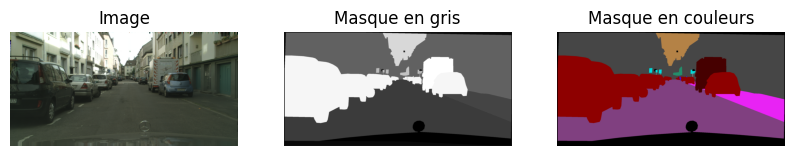

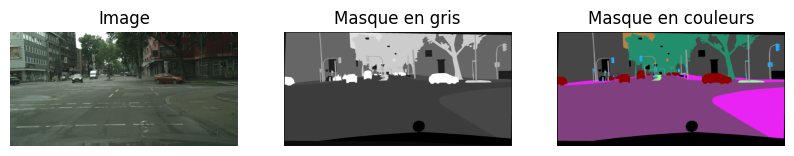

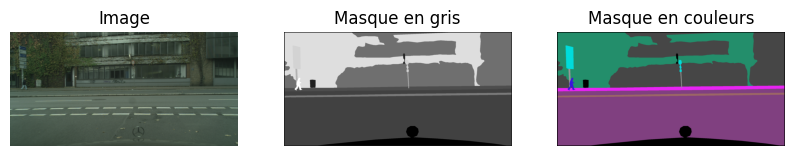

In [19]:
show_random_images_with_masks(df_train, n=3)

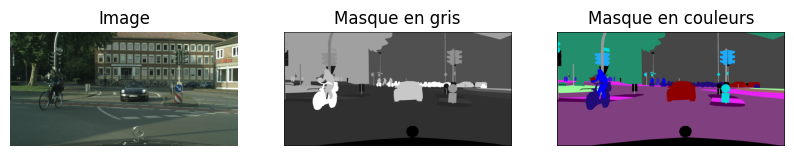

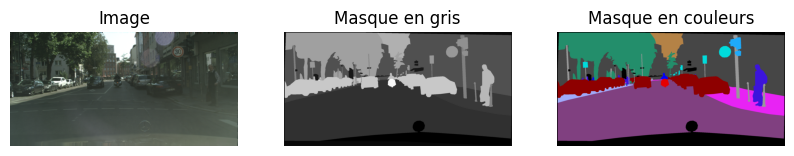

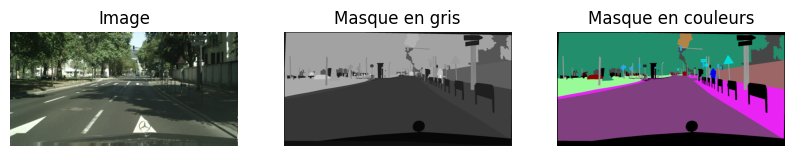

In [20]:
show_random_images_with_masks(df_val, n=3)

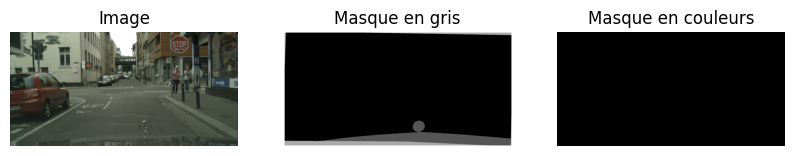

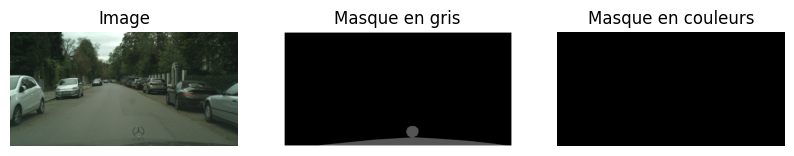

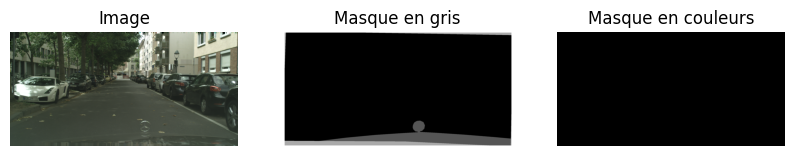

In [21]:
show_random_images_with_masks(df_test, n=3)

In [22]:
image0 = cv2.imread(df_train.iloc[0,0])
mask0 = cv2.imread(df_train.iloc[0,1])

print('Dimension image :', image0.shape)
print('Dimension mask :', mask0.shape)

Dimension image : (1024, 2048, 3)
Dimension mask : (1024, 2048, 3)


In [23]:
sample_size = 300
df_train_sample = df_train.sample(n=sample_size, random_state=42)

# Catégories

In [24]:
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

In [25]:
# Création d'une carte de catégories pour les masques
cat_map = {}
for i, (cat, ids) in enumerate(cats.items()):
    for id_ in ids:
        cat_map[id_] = i

# Entrainement avec VGG16

In [26]:
# Callback pour afficher la prédiction et les graphiques IoU après chaque époque
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        # Générer un index aléatoire une seule fois pour toutes les époques
        self.idx = np.random.randint(len(images))
    
    def on_epoch_end(self, epoch, logs=None):
        plot_sample_prediction(epoch, logs, self.idx)

## Avec 10 époques

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.3858 - dice_coeff: 0.2602 - dice_loss: 0.7398 - jaccard_score: 0.1536 


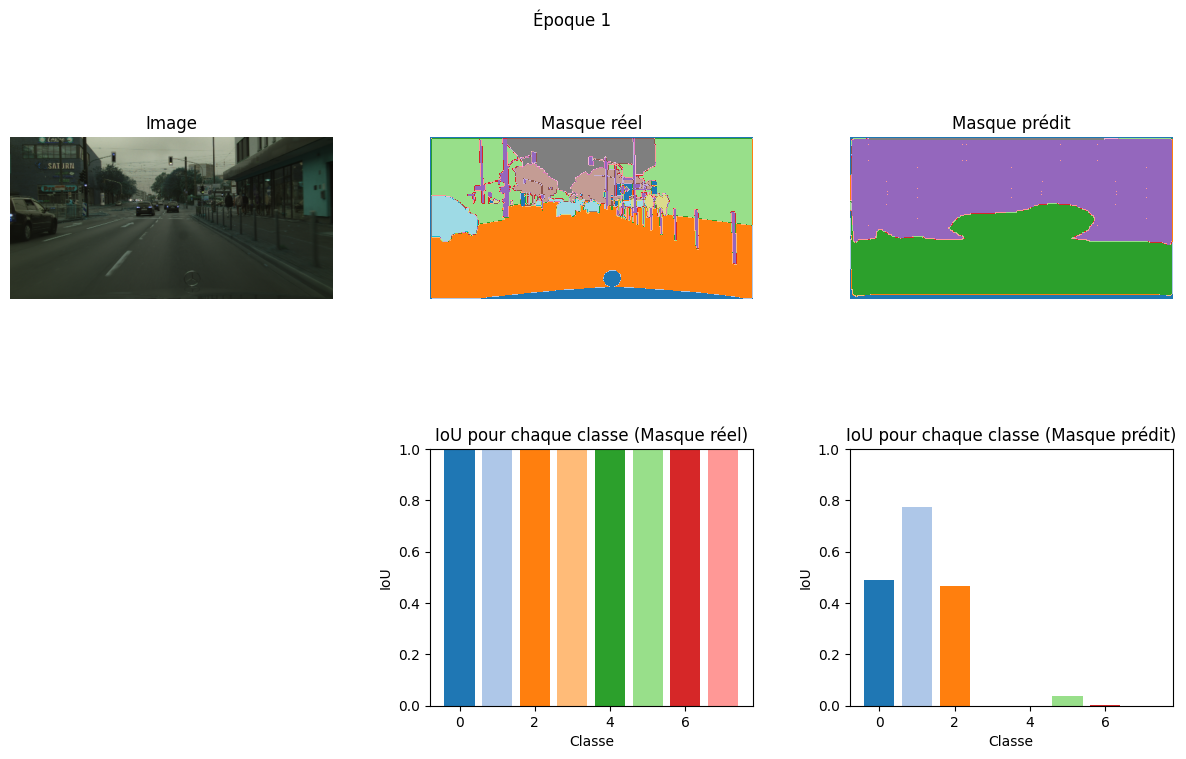

75/75 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.3868 - dice_coeff: 0.2612 - dice_loss: 0.7388 - jaccard_score: 0.1543 - loss: 6.1721 - total_loss: 3.7989
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6152 - dice_coeff: 0.5049 - dice_loss: 0.4951 - jaccard_score: 0.3384 


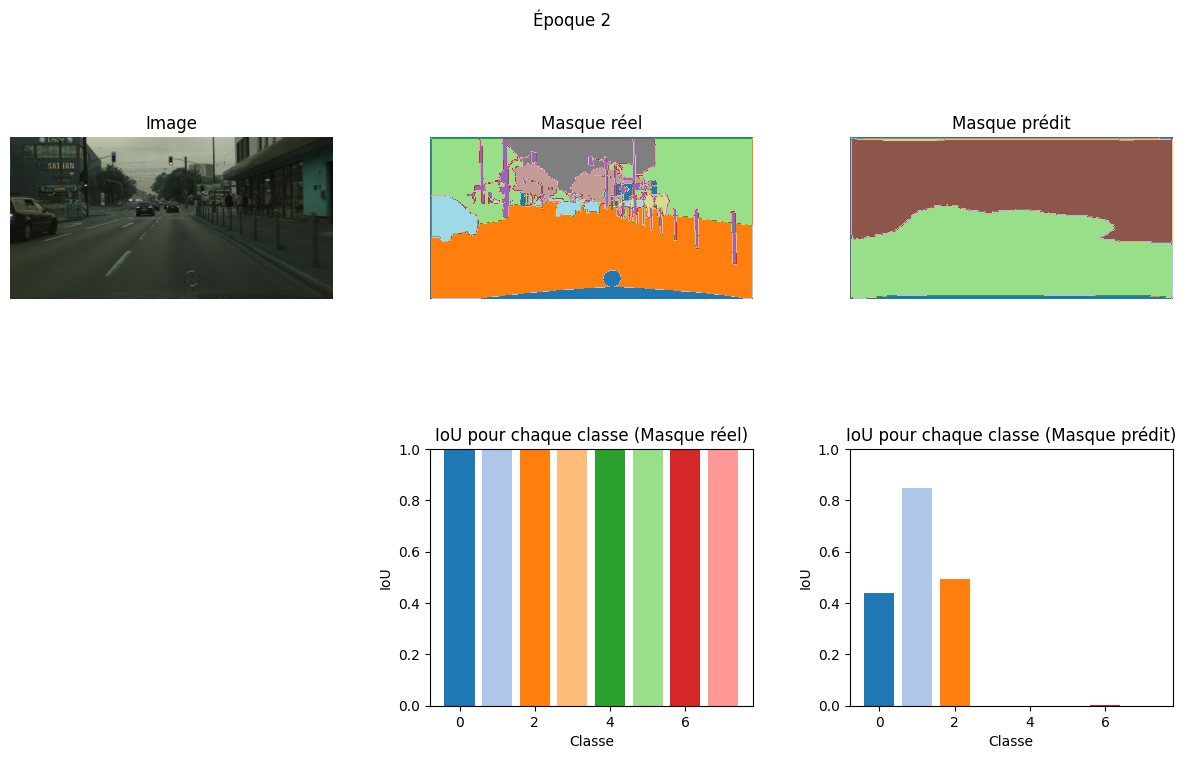

75/75 ━━━━━━━━━━━━━━━━━━━━ 598s 8s/step - accuracy: 0.6152 - dice_coeff: 0.5051 - dice_loss: 0.4949 - jaccard_score: 0.3385 - loss: 1.0385 - total_loss: 1.9269
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6271 - dice_coeff: 0.5395 - dice_loss: 0.4605 - jaccard_score: 0.3702 


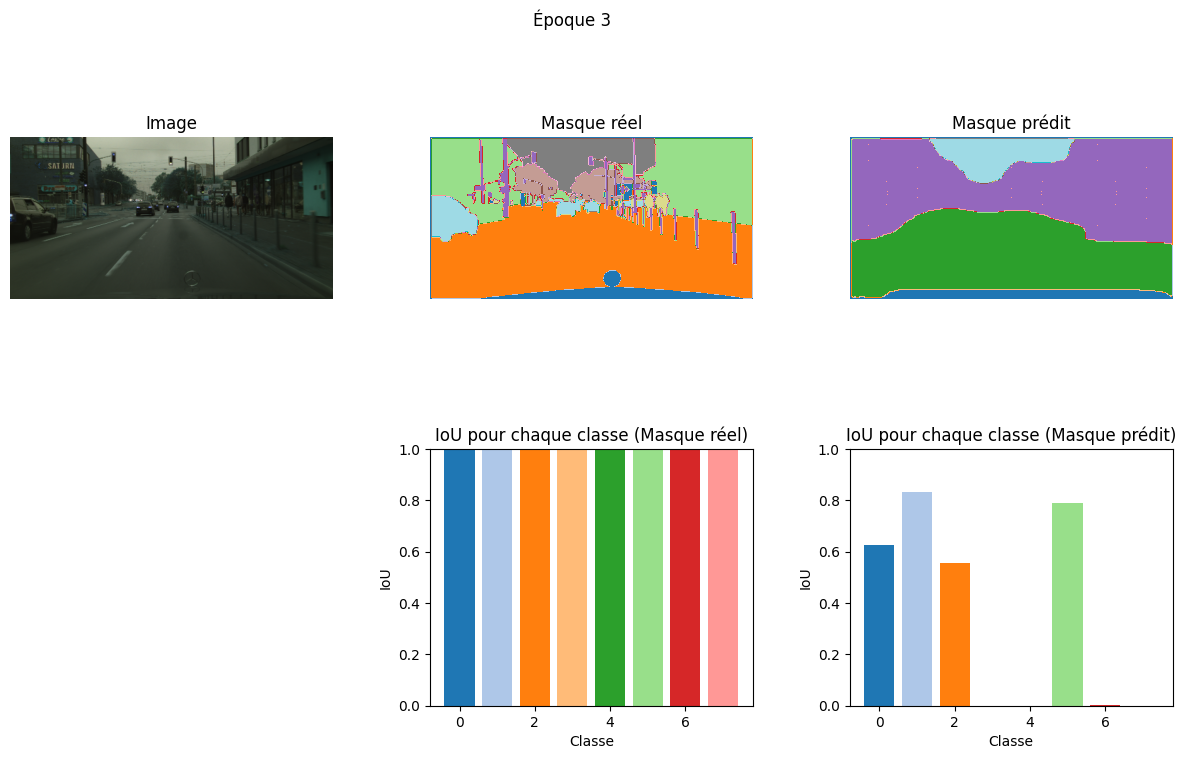

75/75 ━━━━━━━━━━━━━━━━━━━━ 634s 8s/step - accuracy: 0.6272 - dice_coeff: 0.5397 - dice_loss: 0.4603 - jaccard_score: 0.3703 - loss: 0.9445 - total_loss: 1.8449
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6623 - dice_coeff: 0.5711 - dice_loss: 0.4289 - jaccard_score: 0.4006 


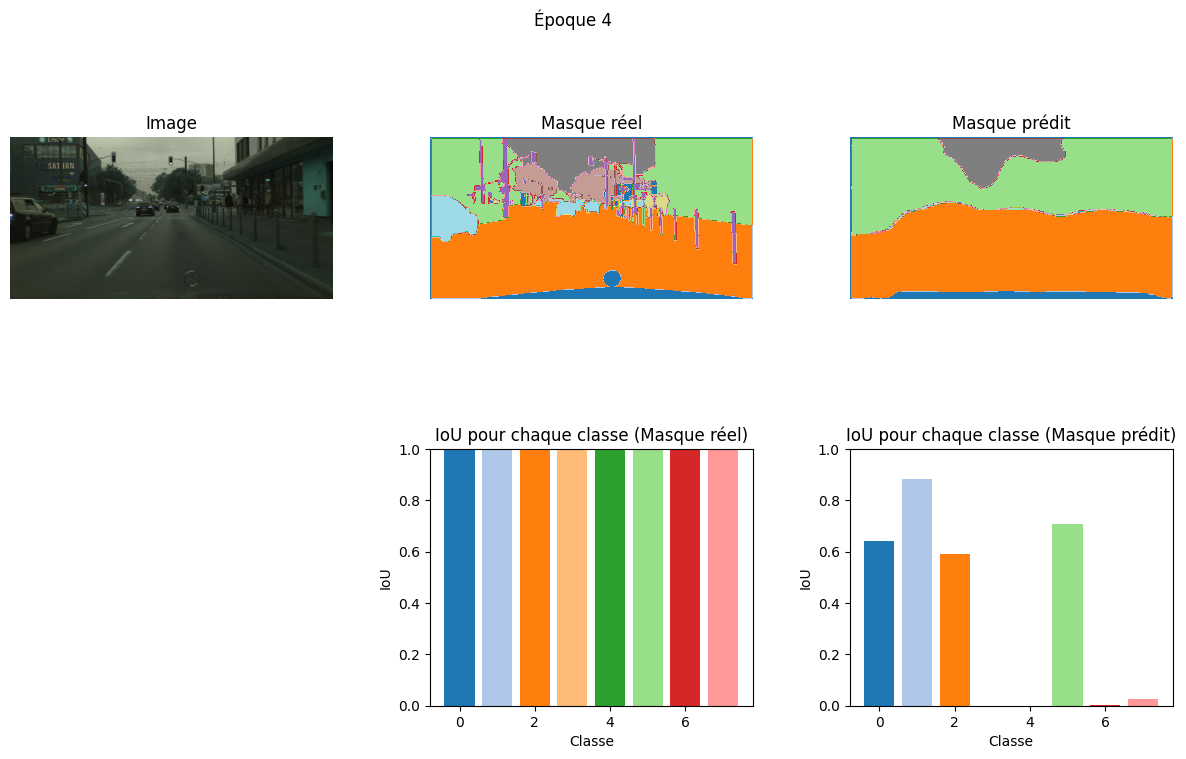

75/75 ━━━━━━━━━━━━━━━━━━━━ 615s 8s/step - accuracy: 0.6624 - dice_coeff: 0.5712 - dice_loss: 0.4288 - jaccard_score: 0.4007 - loss: 0.8705 - total_loss: 1.7769
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6685 - dice_coeff: 0.5793 - dice_loss: 0.4207 - jaccard_score: 0.4090 


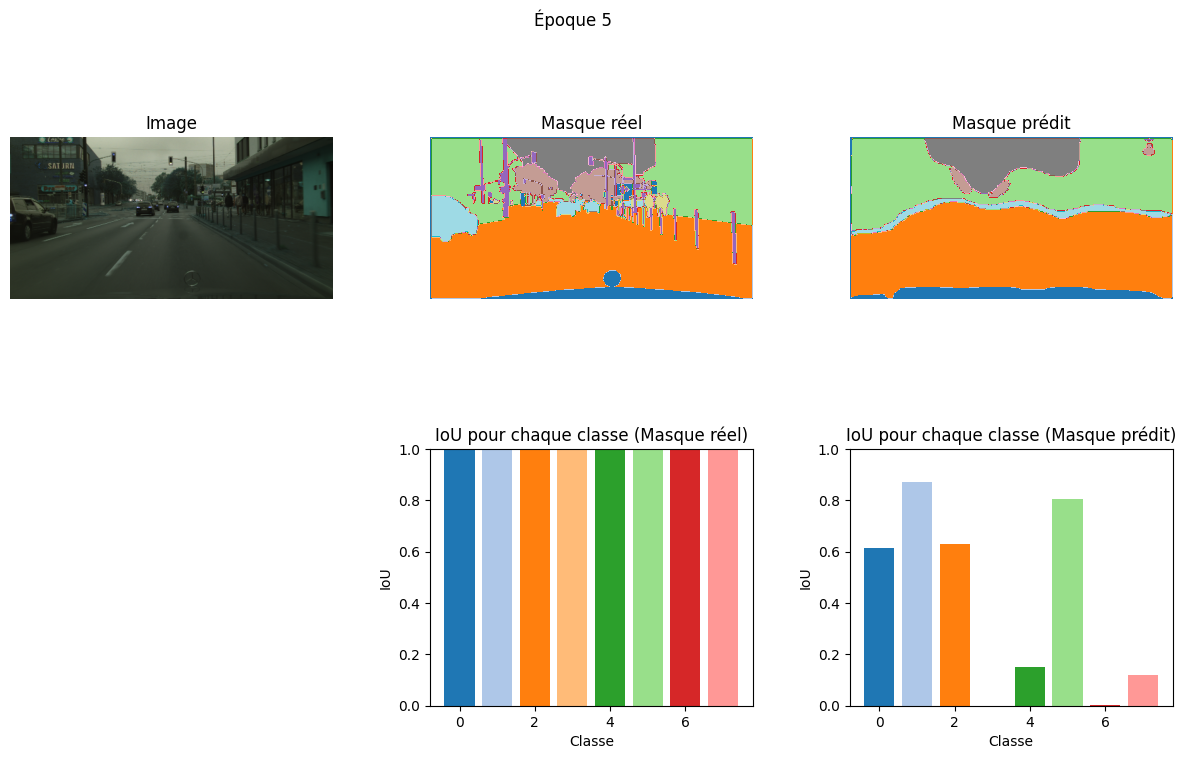

75/75 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.6687 - dice_coeff: 0.5795 - dice_loss: 0.4205 - jaccard_score: 0.4091 - loss: 0.8789 - total_loss: 1.7397
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6958 - dice_coeff: 0.5998 - dice_loss: 0.4002 - jaccard_score: 0.4298 


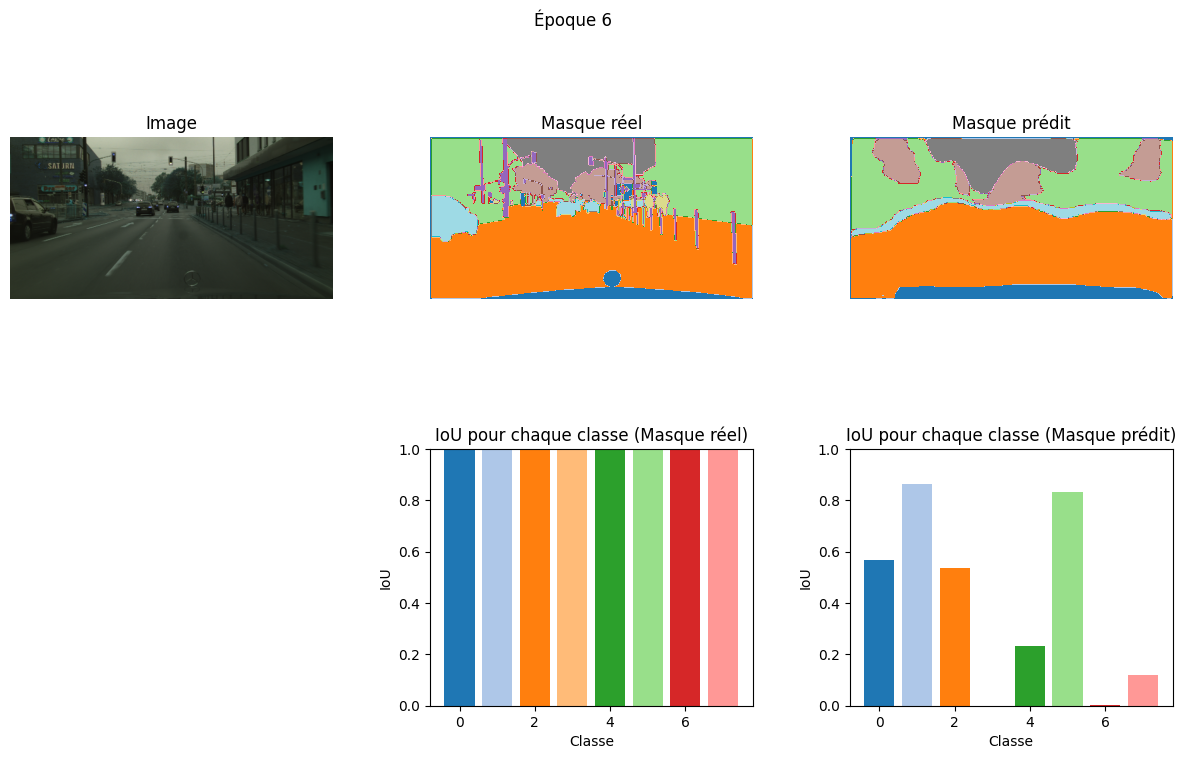

75/75 ━━━━━━━━━━━━━━━━━━━━ 618s 8s/step - accuracy: 0.6960 - dice_coeff: 0.5999 - dice_loss: 0.4001 - jaccard_score: 0.4300 - loss: 0.8301 - total_loss: 1.7131
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7230 - dice_coeff: 0.6352 - dice_loss: 0.3648 - jaccard_score: 0.4667 


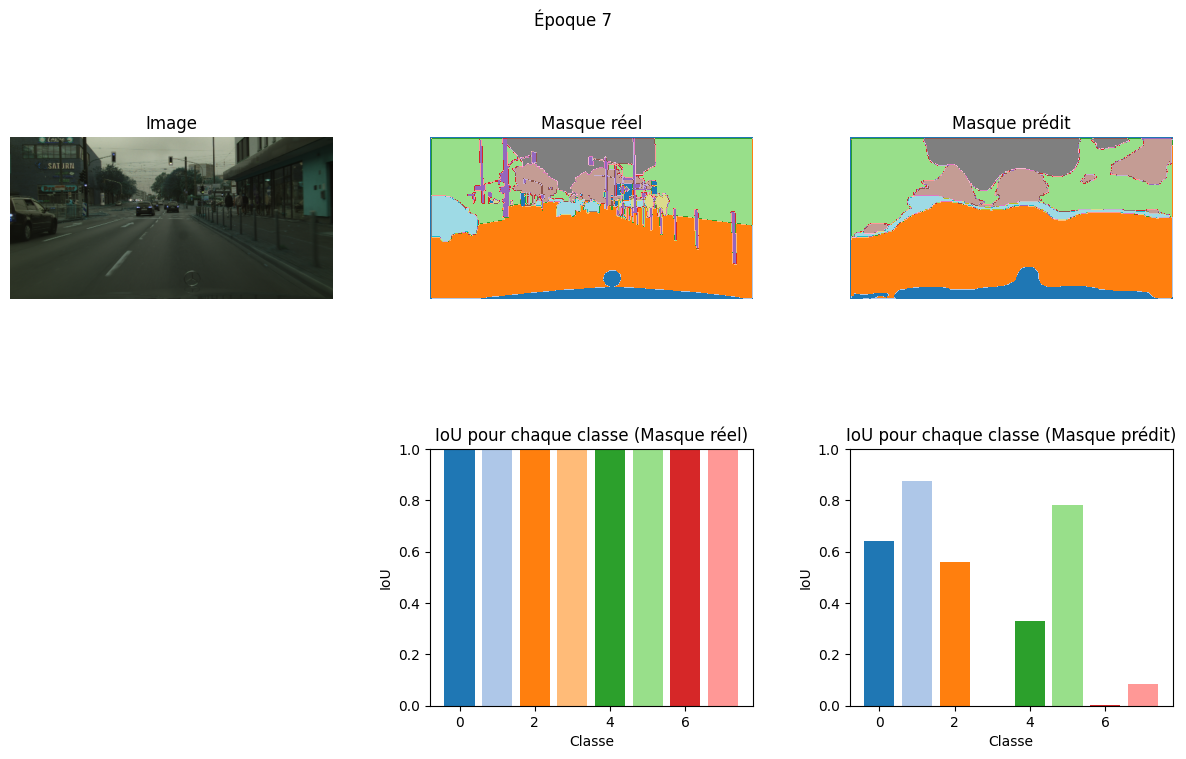

75/75 ━━━━━━━━━━━━━━━━━━━━ 613s 8s/step - accuracy: 0.7231 - dice_coeff: 0.6353 - dice_loss: 0.3647 - jaccard_score: 0.4668 - loss: 0.7636 - total_loss: 1.5824
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.7507 - dice_coeff: 0.6537 - dice_loss: 0.3463 - jaccard_score: 0.4870 


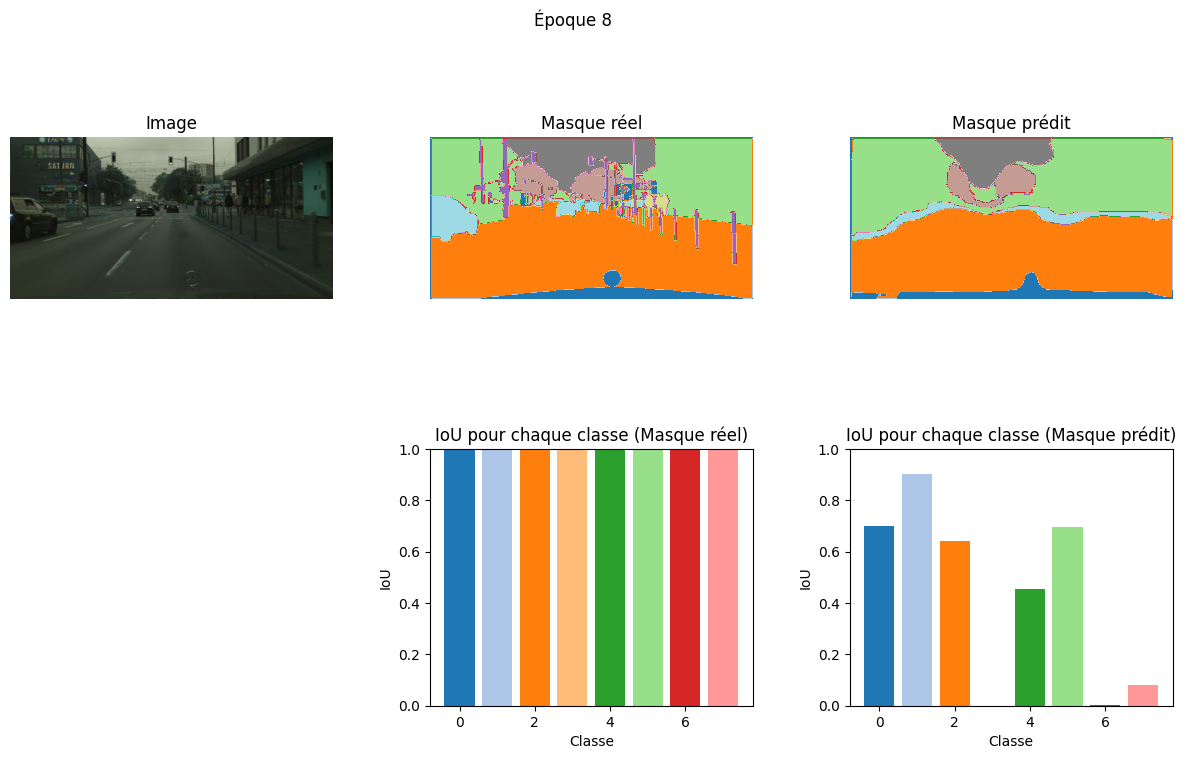

75/75 ━━━━━━━━━━━━━━━━━━━━ 625s 8s/step - accuracy: 0.7507 - dice_coeff: 0.6538 - dice_loss: 0.3462 - jaccard_score: 0.4871 - loss: 0.7157 - total_loss: 1.5154
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.7731 - dice_coeff: 0.6792 - dice_loss: 0.3208 - jaccard_score: 0.5153 


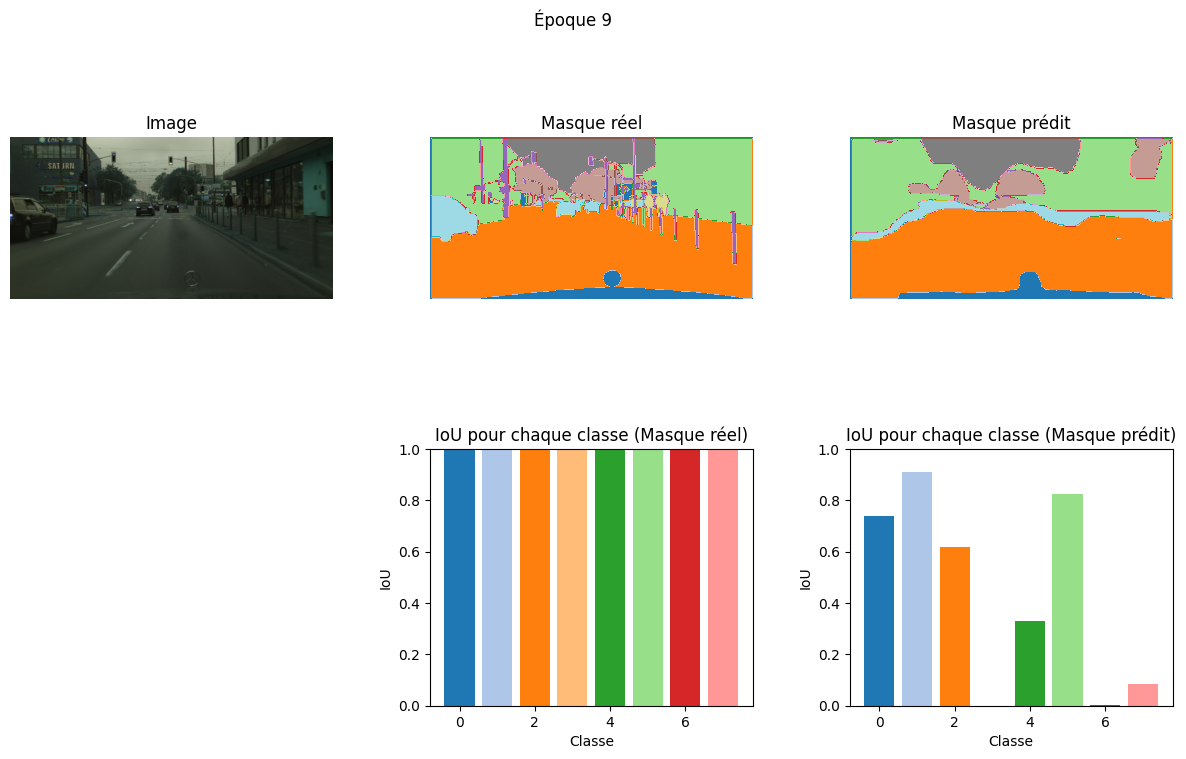

75/75 ━━━━━━━━━━━━━━━━━━━━ 661s 9s/step - accuracy: 0.7731 - dice_coeff: 0.6792 - dice_loss: 0.3208 - jaccard_score: 0.5153 - loss: 0.6787 - total_loss: 1.4588
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.7731 - dice_coeff: 0.6777 - dice_loss: 0.3223 - jaccard_score: 0.5139 


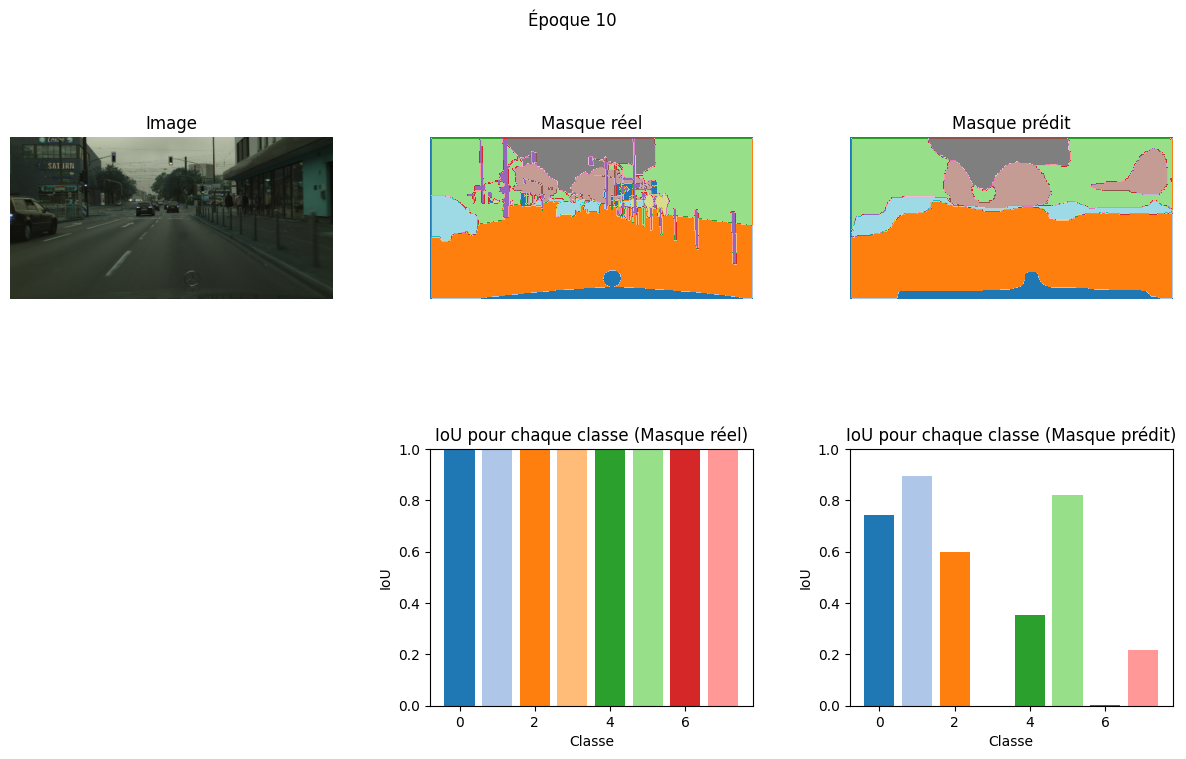

75/75 ━━━━━━━━━━━━━━━━━━━━ 642s 9s/step - accuracy: 0.7731 - dice_coeff: 0.6777 - dice_loss: 0.3223 - jaccard_score: 0.5140 - loss: 0.6857 - total_loss: 1.4632


In [35]:
### Chargement des données
images = load_images(df_train_sample)  # Charger les images
masks = load_masks(df_train_sample)    # Charger les masques

# Construction du modèle de segmentation
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 512, 3))

# Utilisation de la sortie d'un bloc intermédiaire pour conserver des détails spatiaux
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
x = layer_dict['block5_conv3'].output

# Ajout de couches de déconvolution pour la segmentation
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Dernière couche pour le nombre de classes
output = Conv2D(len(cats), (1, 1), padding='same', activation='softmax')(x)

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, dice_loss, total_loss, jaccard_score, 'accuracy'])

# Entraînement du modèle avec le callback
# history = model.fit(
#     images,
#     masks,
#     batch_size=4,
#     epochs=10,
#     callbacks=[PredictionCallback()]
# )

## Avec 20 époques

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.3058 - dice_coeff: 0.2170 - dice_loss: 0.7830 - jaccard_score: 0.1240 


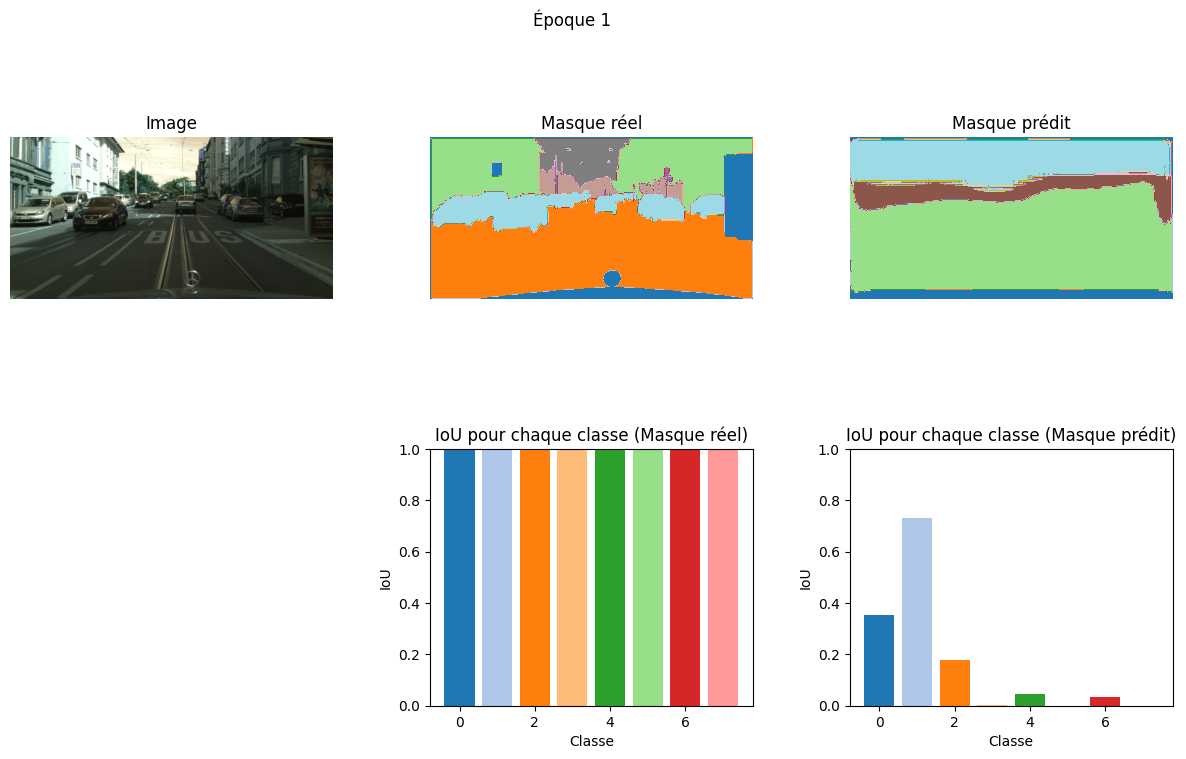

75/75 ━━━━━━━━━━━━━━━━━━━━ 639s 8s/step - accuracy: 0.3070 - dice_coeff: 0.2179 - dice_loss: 0.7821 - jaccard_score: 0.1246 - loss: 2.3719 - total_loss: 3.3831
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.5896 - dice_coeff: 0.4997 - dice_loss: 0.5003 - jaccard_score: 0.3339 


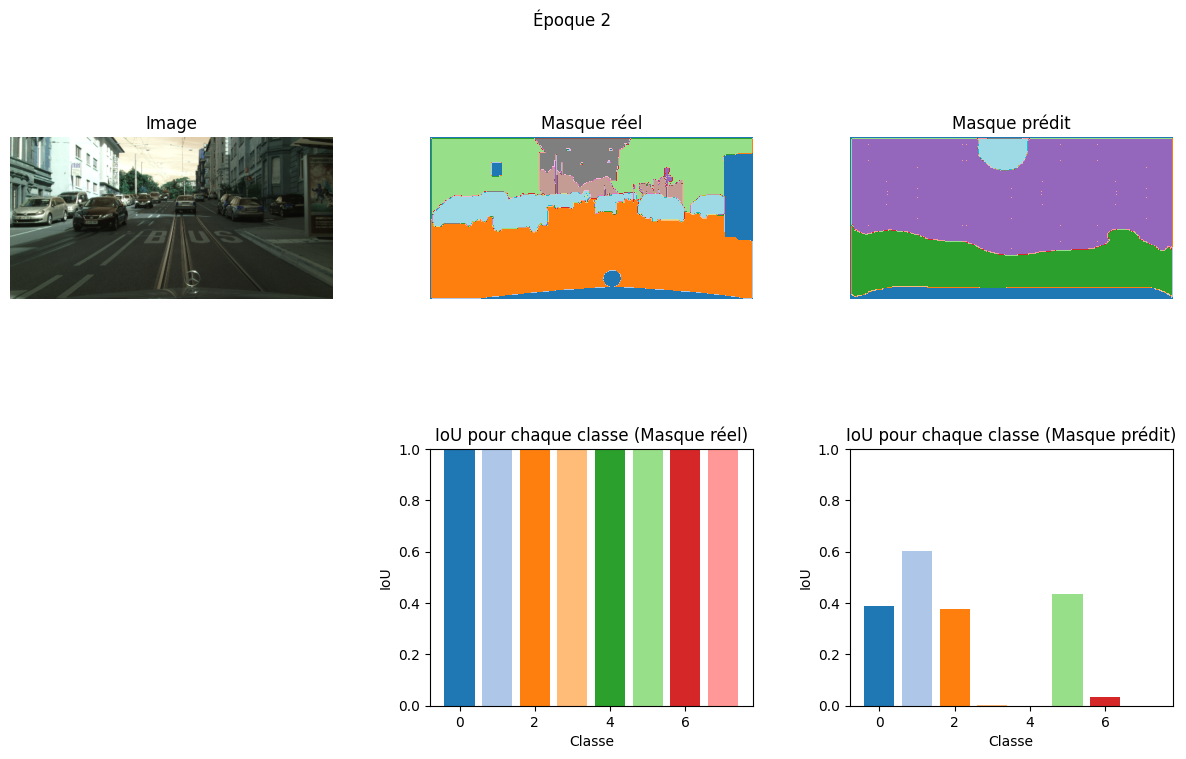

75/75 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.5899 - dice_coeff: 0.5000 - dice_loss: 0.5000 - jaccard_score: 0.3342 - loss: 1.0505 - total_loss: 2.2397
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6504 - dice_coeff: 0.5674 - dice_loss: 0.4326 - jaccard_score: 0.3967 


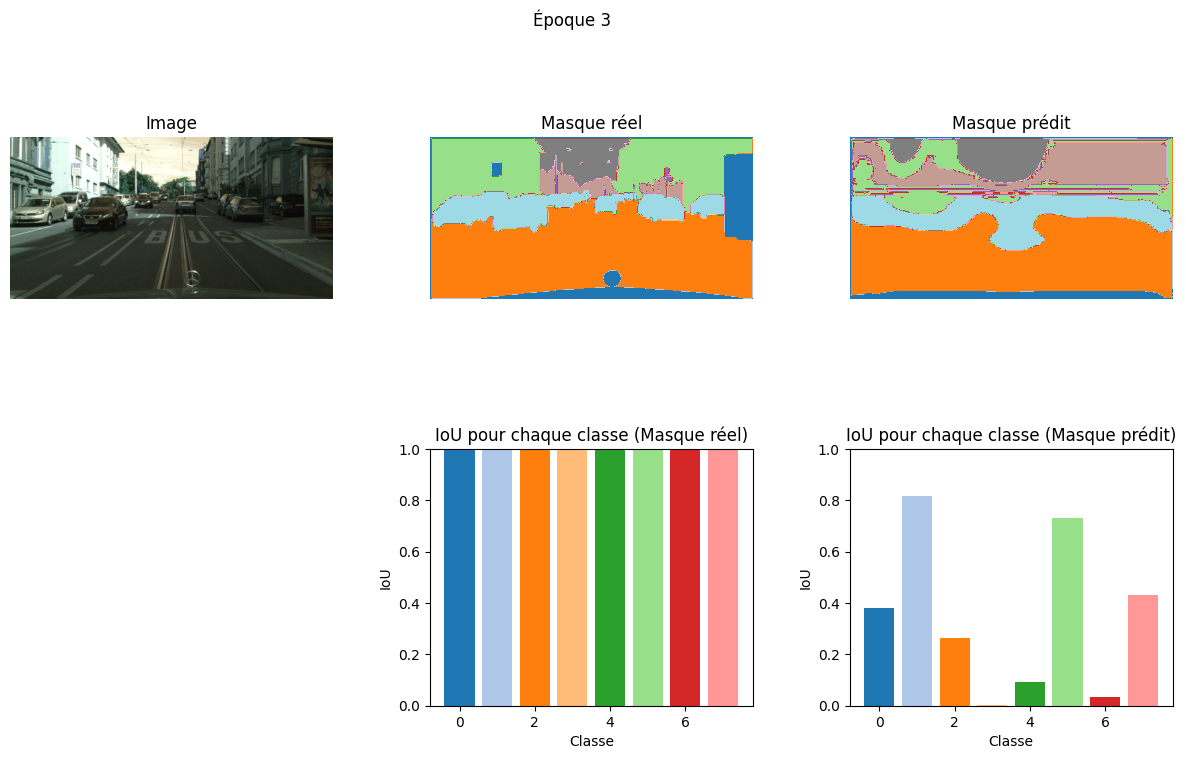

75/75 ━━━━━━━━━━━━━━━━━━━━ 629s 8s/step - accuracy: 0.6503 - dice_coeff: 0.5673 - dice_loss: 0.4327 - jaccard_score: 0.3966 - loss: 0.8817 - total_loss: 2.0440
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.6533 - dice_coeff: 0.5763 - dice_loss: 0.4237 - jaccard_score: 0.4059 


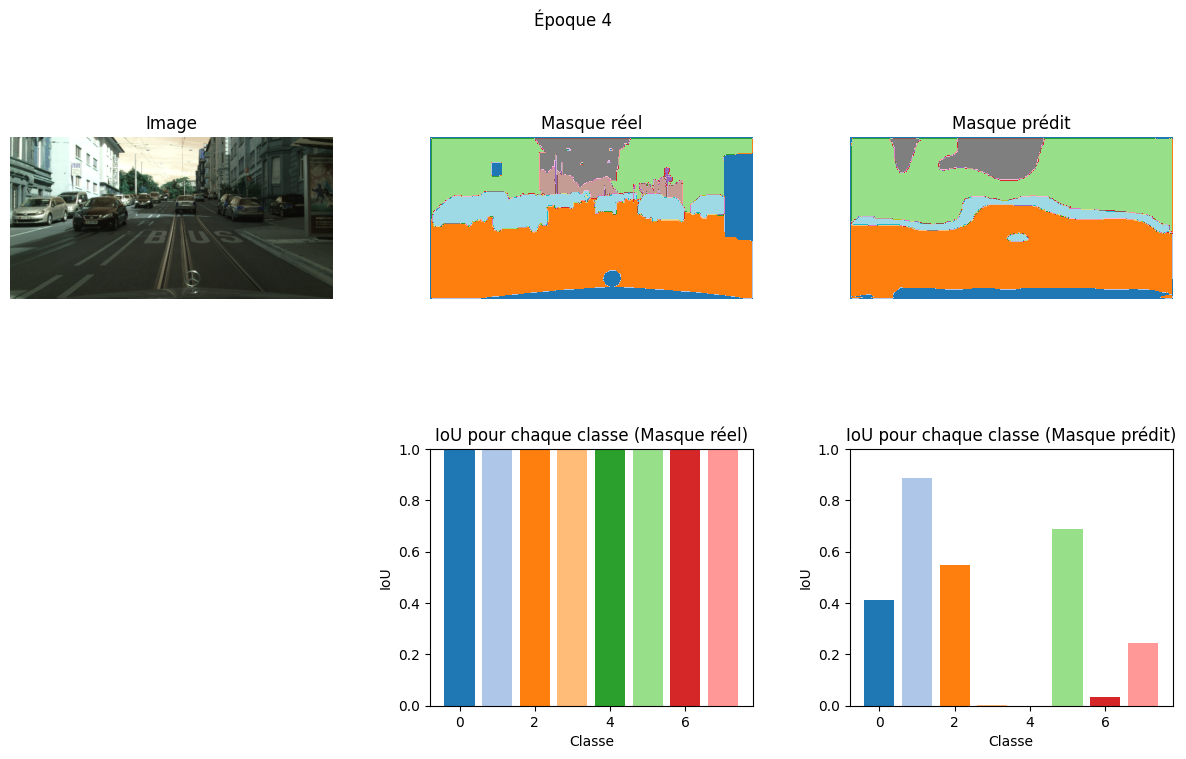

75/75 ━━━━━━━━━━━━━━━━━━━━ 628s 8s/step - accuracy: 0.6534 - dice_coeff: 0.5764 - dice_loss: 0.4236 - jaccard_score: 0.4059 - loss: 0.8498 - total_loss: 2.0555
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.6617 - dice_coeff: 0.5807 - dice_loss: 0.4193 - jaccard_score: 0.4101 


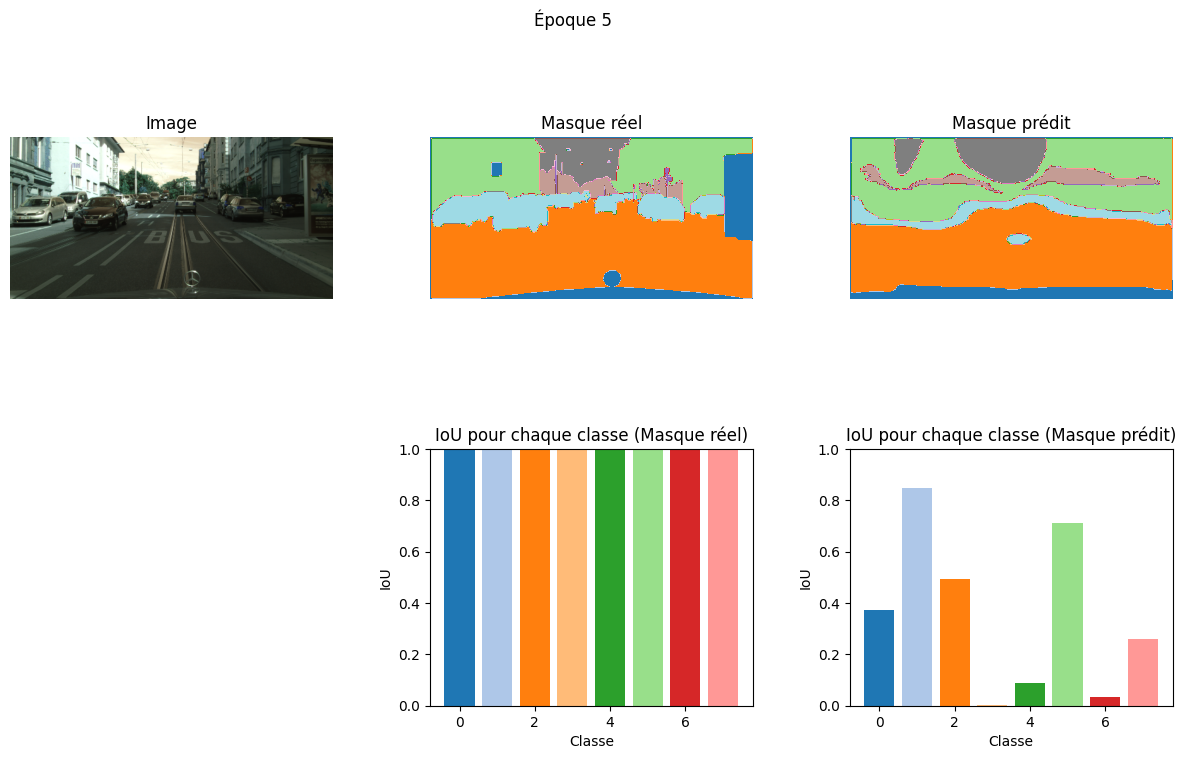

75/75 ━━━━━━━━━━━━━━━━━━━━ 650s 9s/step - accuracy: 0.6617 - dice_coeff: 0.5807 - dice_loss: 0.4193 - jaccard_score: 0.4101 - loss: 0.8586 - total_loss: 2.0505
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.6678 - dice_coeff: 0.5953 - dice_loss: 0.4047 - jaccard_score: 0.4245 


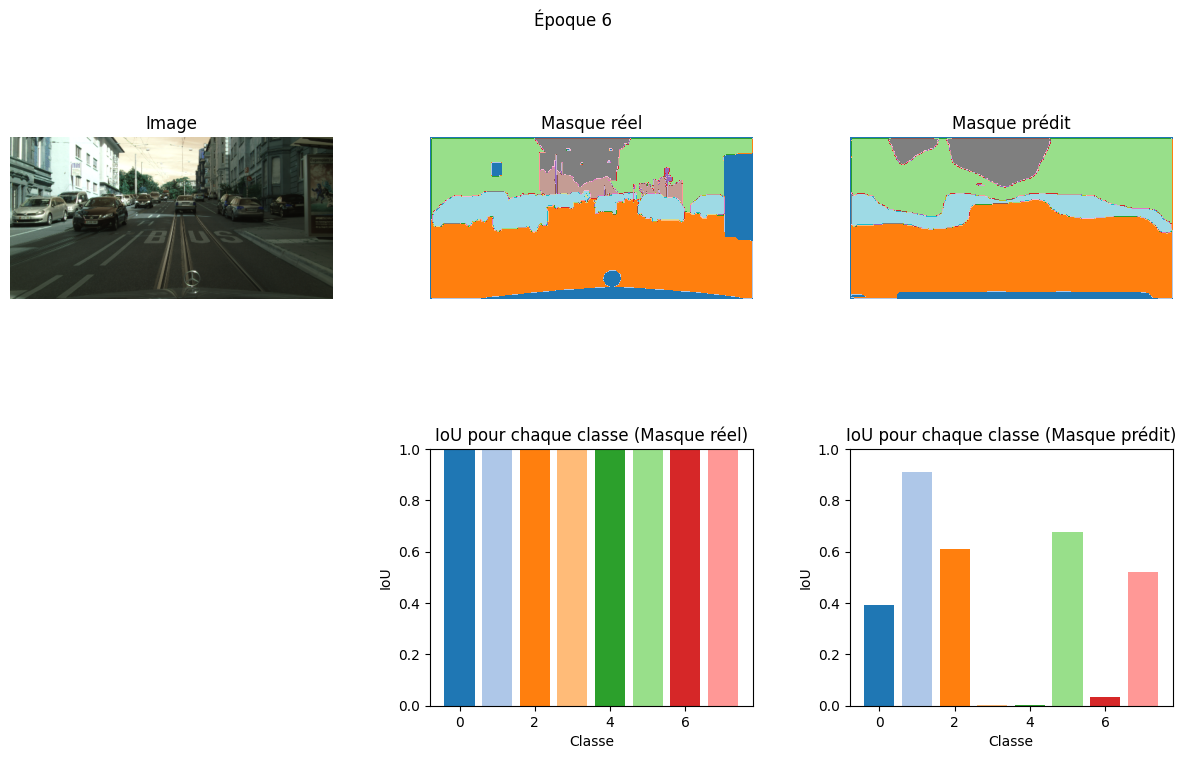

75/75 ━━━━━━━━━━━━━━━━━━━━ 650s 9s/step - accuracy: 0.6680 - dice_coeff: 0.5954 - dice_loss: 0.4046 - jaccard_score: 0.4246 - loss: 0.8075 - total_loss: 1.9982
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7022 - dice_coeff: 0.6085 - dice_loss: 0.3915 - jaccard_score: 0.4390 


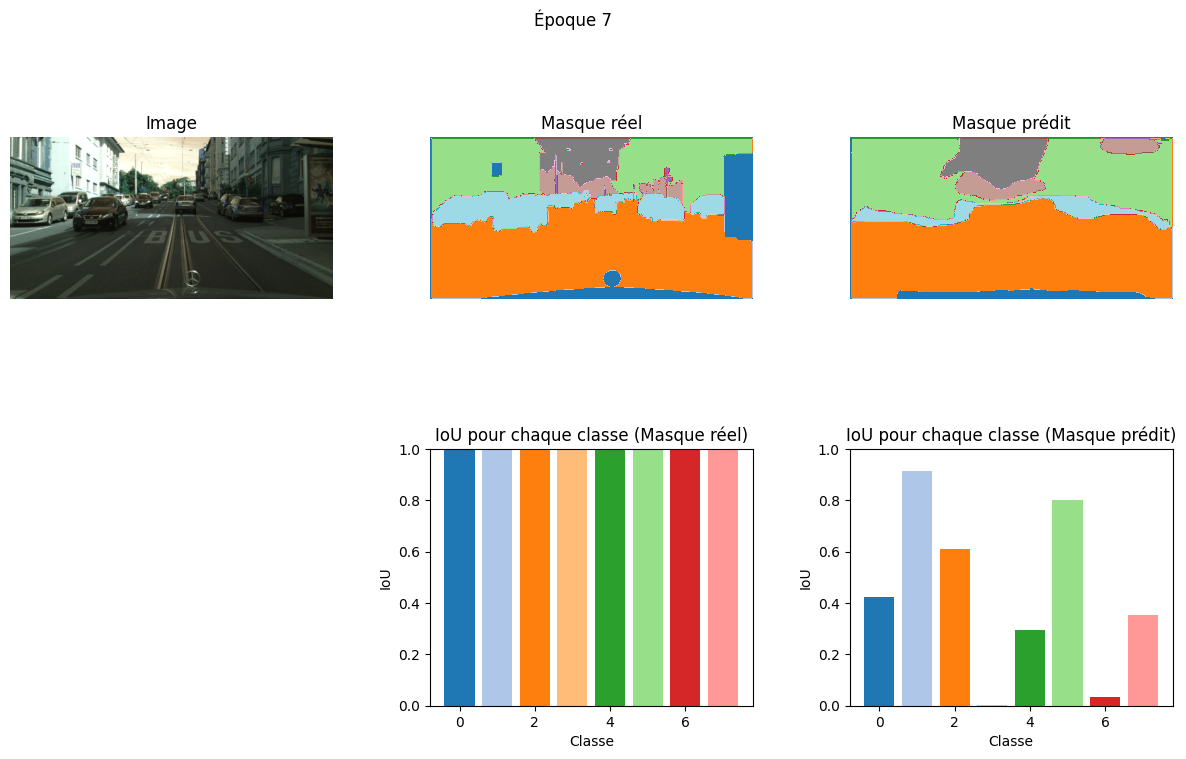

75/75 ━━━━━━━━━━━━━━━━━━━━ 637s 8s/step - accuracy: 0.7024 - dice_coeff: 0.6088 - dice_loss: 0.3912 - jaccard_score: 0.4392 - loss: 0.7977 - total_loss: 1.9438
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7531 - dice_coeff: 0.6592 - dice_loss: 0.3408 - jaccard_score: 0.4936 


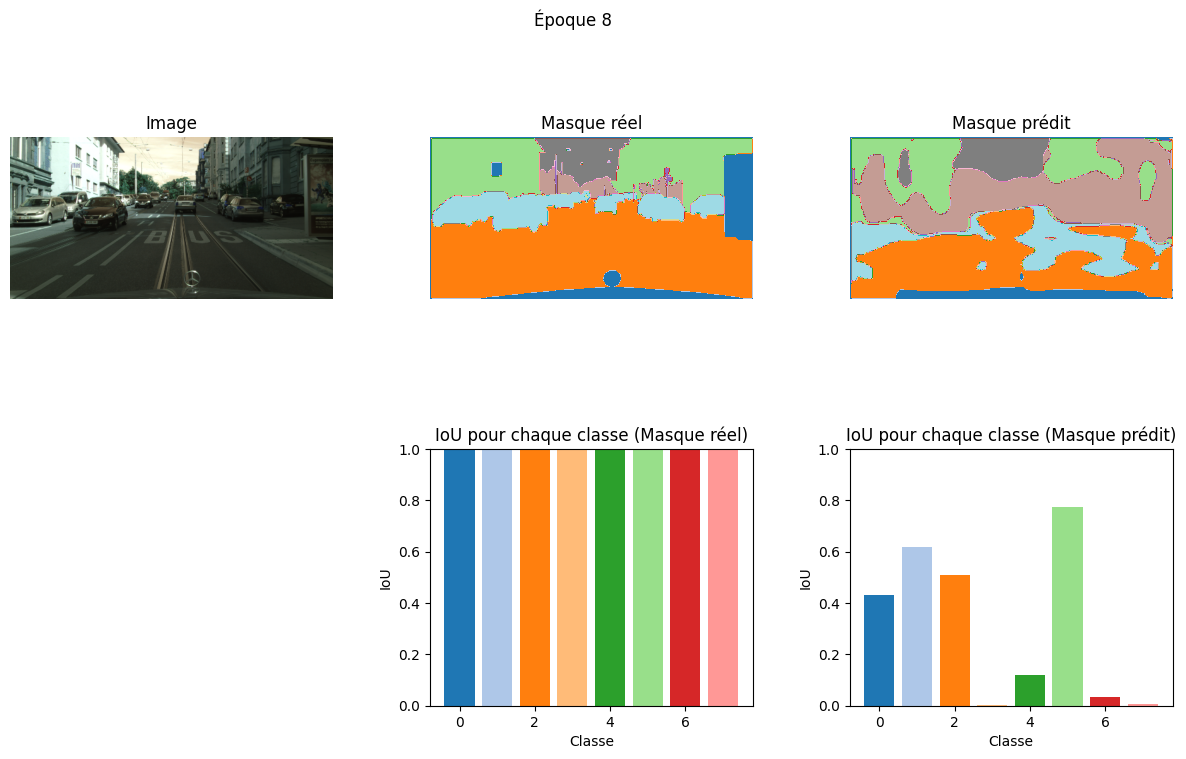

75/75 ━━━━━━━━━━━━━━━━━━━━ 632s 8s/step - accuracy: 0.7532 - dice_coeff: 0.6593 - dice_loss: 0.3407 - jaccard_score: 0.4937 - loss: 0.7123 - total_loss: 1.8443
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7445 - dice_coeff: 0.6593 - dice_loss: 0.3407 - jaccard_score: 0.4931 


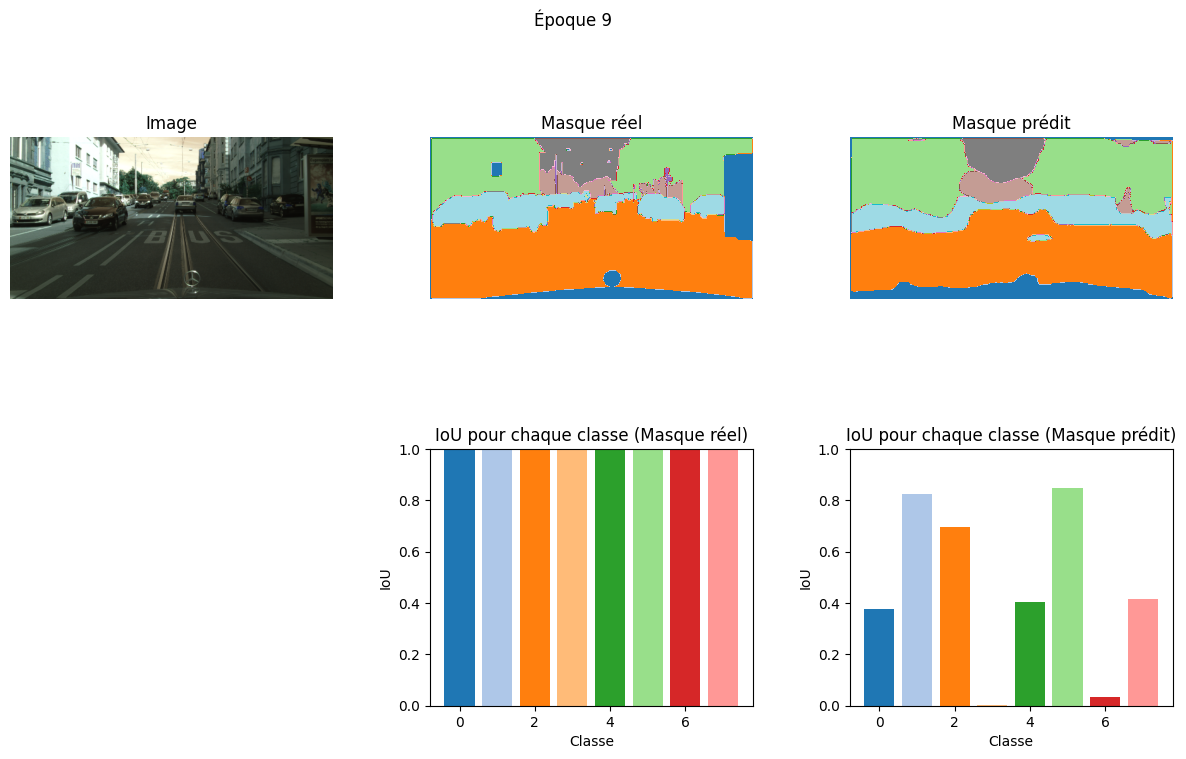

75/75 ━━━━━━━━━━━━━━━━━━━━ 621s 8s/step - accuracy: 0.7447 - dice_coeff: 0.6595 - dice_loss: 0.3405 - jaccard_score: 0.4933 - loss: 0.7255 - total_loss: 1.7705
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7884 - dice_coeff: 0.7001 - dice_loss: 0.2999 - jaccard_score: 0.5397 


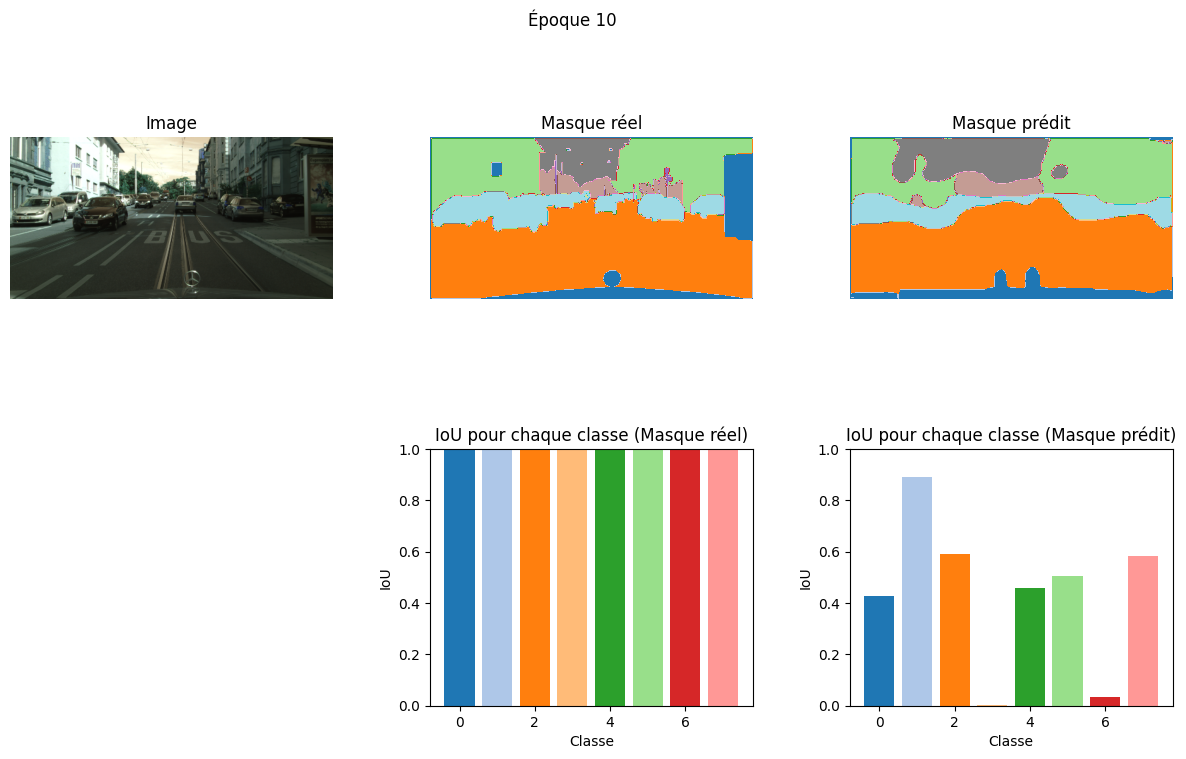

75/75 ━━━━━━━━━━━━━━━━━━━━ 628s 8s/step - accuracy: 0.7883 - dice_coeff: 0.7001 - dice_loss: 0.2999 - jaccard_score: 0.5397 - loss: 0.6377 - total_loss: 1.6954
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7619 - dice_coeff: 0.6528 - dice_loss: 0.3472 - jaccard_score: 0.4868 


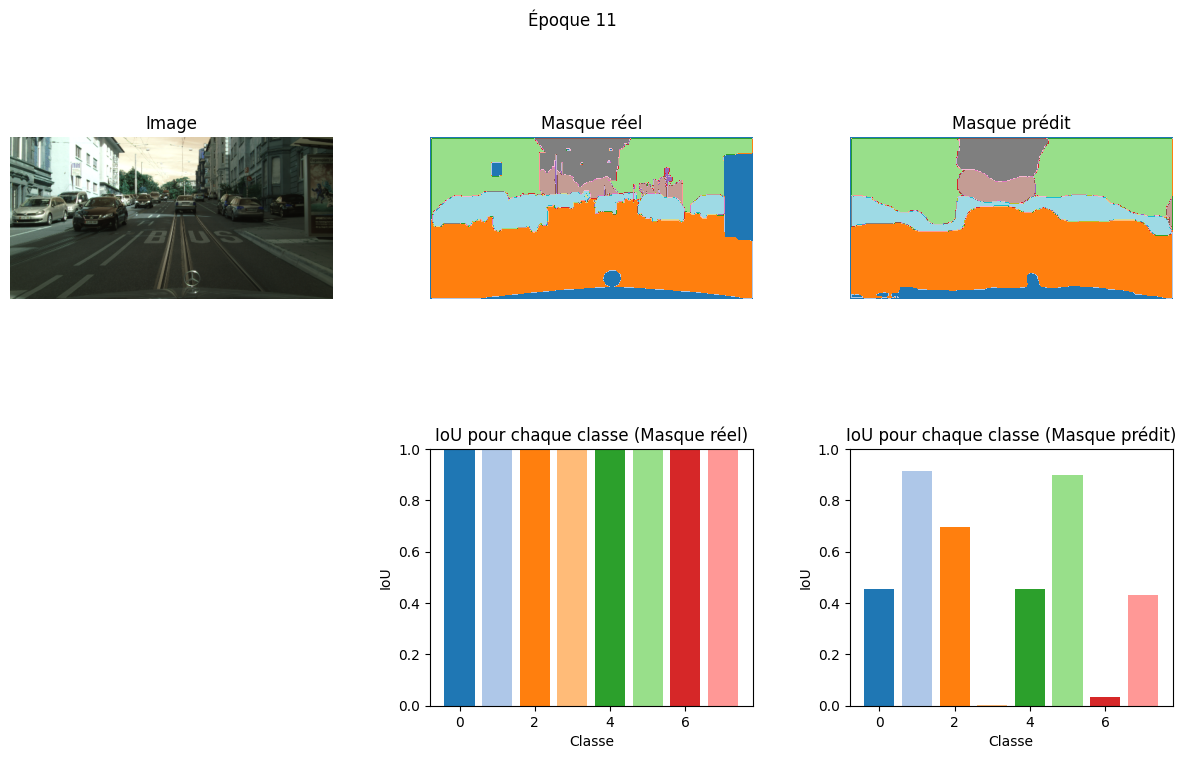

75/75 ━━━━━━━━━━━━━━━━━━━━ 627s 8s/step - accuracy: 0.7620 - dice_coeff: 0.6531 - dice_loss: 0.3469 - jaccard_score: 0.4871 - loss: 0.7120 - total_loss: 1.7910
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.7957 - dice_coeff: 0.7080 - dice_loss: 0.2920 - jaccard_score: 0.5490 


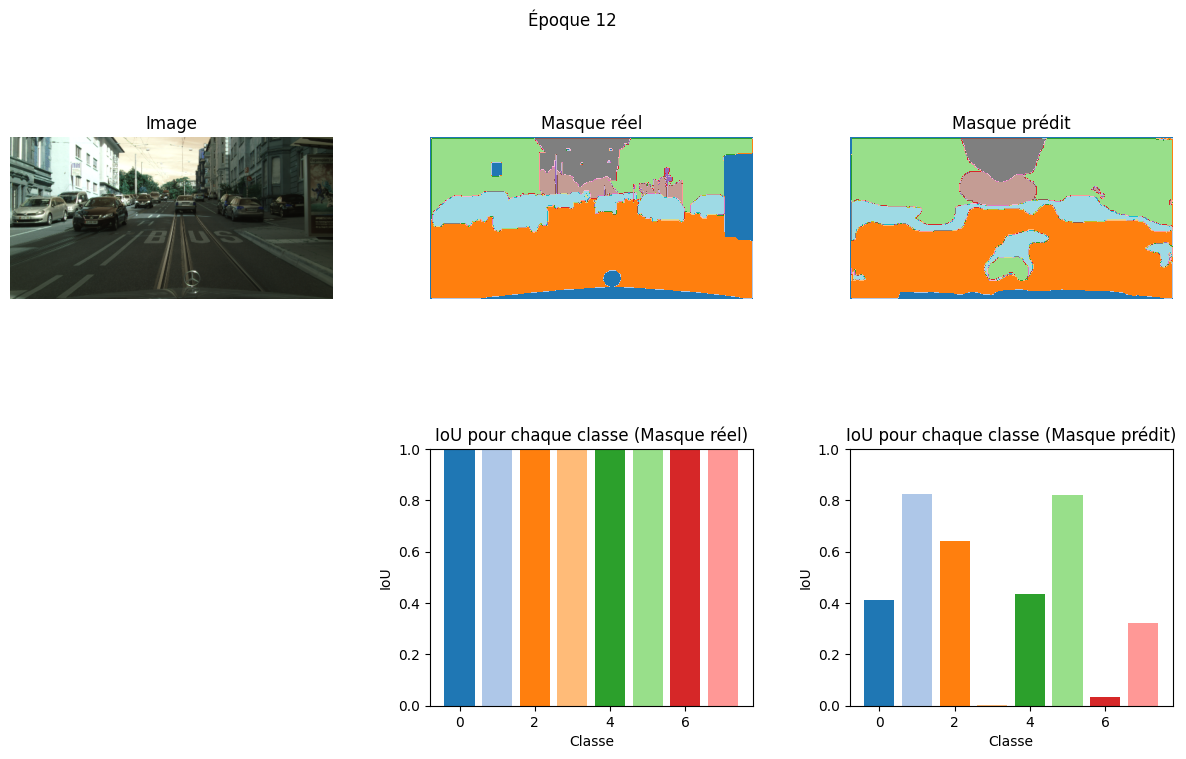

75/75 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.7958 - dice_coeff: 0.7081 - dice_loss: 0.2919 - jaccard_score: 0.5492 - loss: 0.6257 - total_loss: 1.6794
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.8180 - dice_coeff: 0.7373 - dice_loss: 0.2627 - jaccard_score: 0.5848 


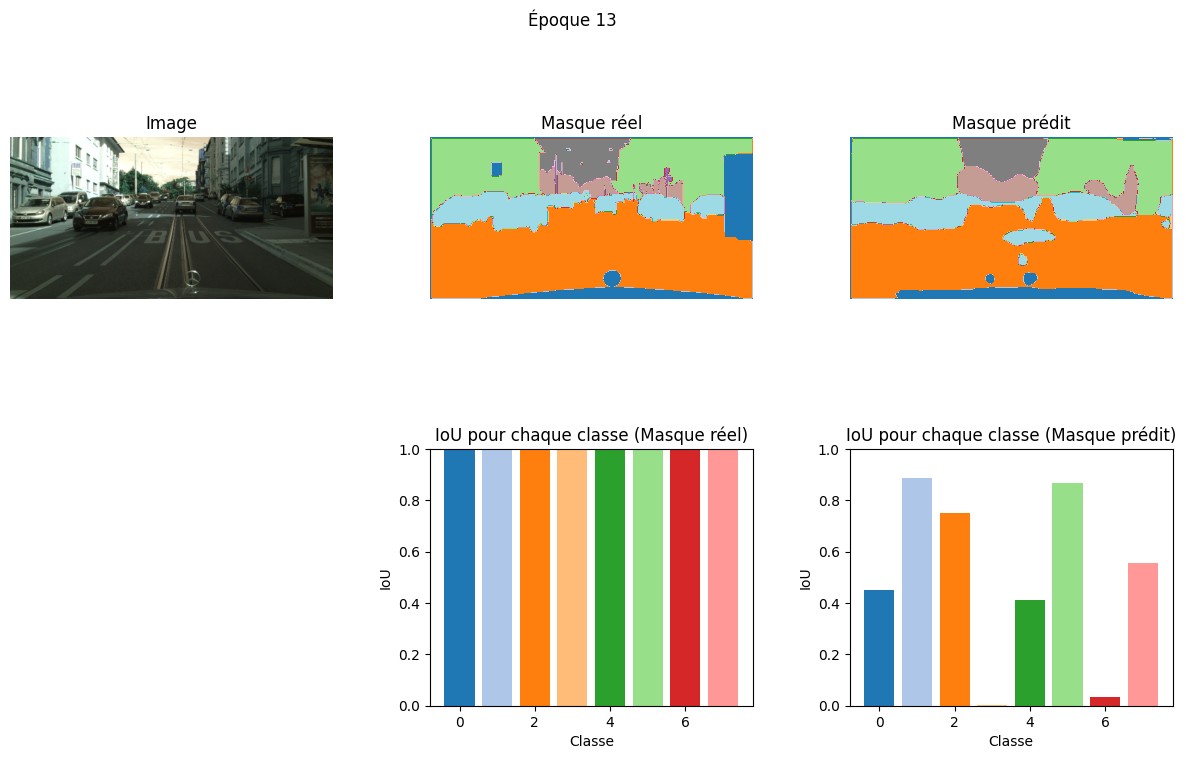

75/75 ━━━━━━━━━━━━━━━━━━━━ 625s 8s/step - accuracy: 0.8180 - dice_coeff: 0.7373 - dice_loss: 0.2627 - jaccard_score: 0.5848 - loss: 0.5702 - total_loss: 1.5936
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.8146 - dice_coeff: 0.7300 - dice_loss: 0.2700 - jaccard_score: 0.5764 


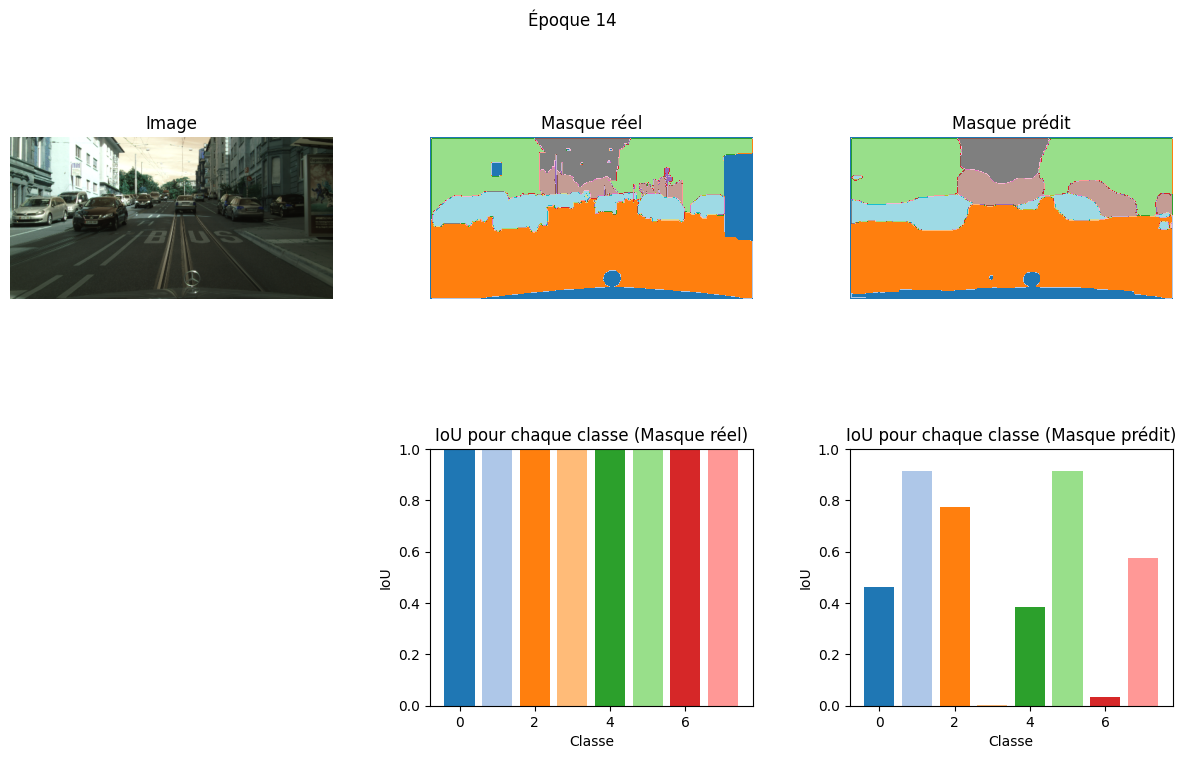

75/75 ━━━━━━━━━━━━━━━━━━━━ 635s 8s/step - accuracy: 0.8146 - dice_coeff: 0.7300 - dice_loss: 0.2700 - jaccard_score: 0.5764 - loss: 0.5848 - total_loss: 1.6440
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.8286 - dice_coeff: 0.7532 - dice_loss: 0.2468 - jaccard_score: 0.6051 


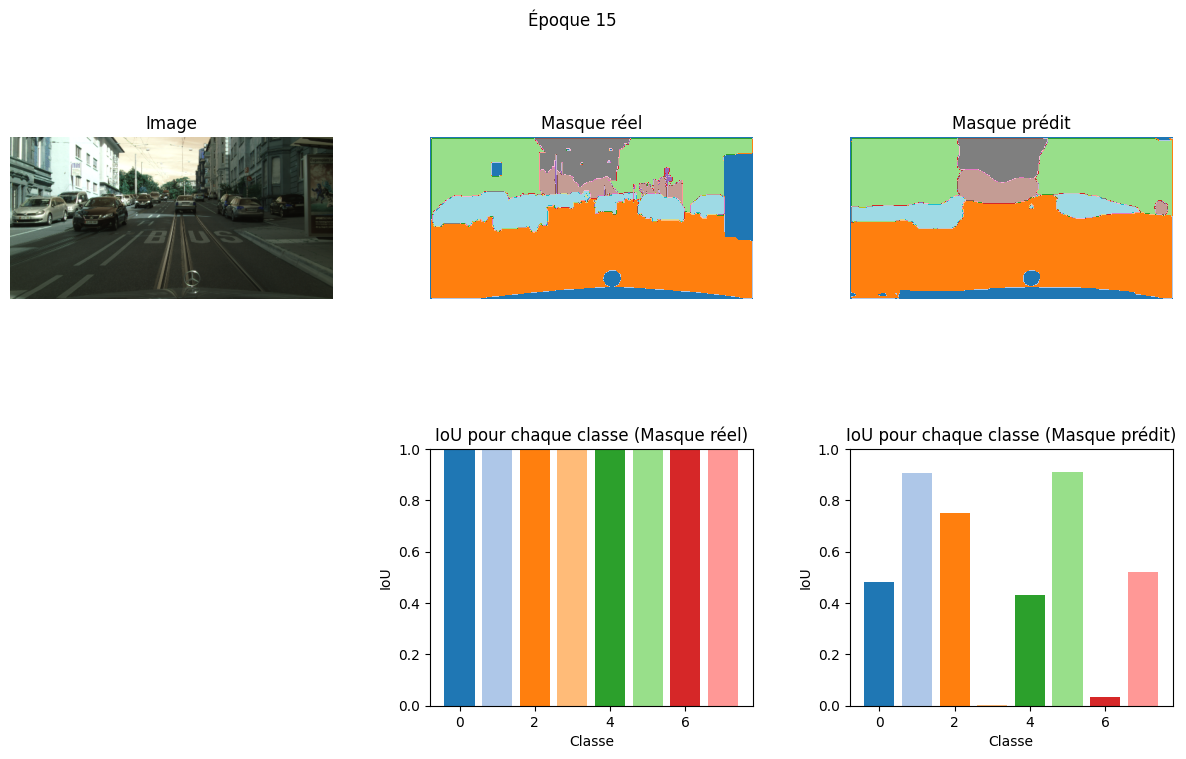

75/75 ━━━━━━━━━━━━━━━━━━━━ 637s 9s/step - accuracy: 0.8285 - dice_coeff: 0.7531 - dice_loss: 0.2469 - jaccard_score: 0.6049 - loss: 0.5398 - total_loss: 1.5623
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.8371 - dice_coeff: 0.7639 - dice_loss: 0.2361 - jaccard_score: 0.6198 


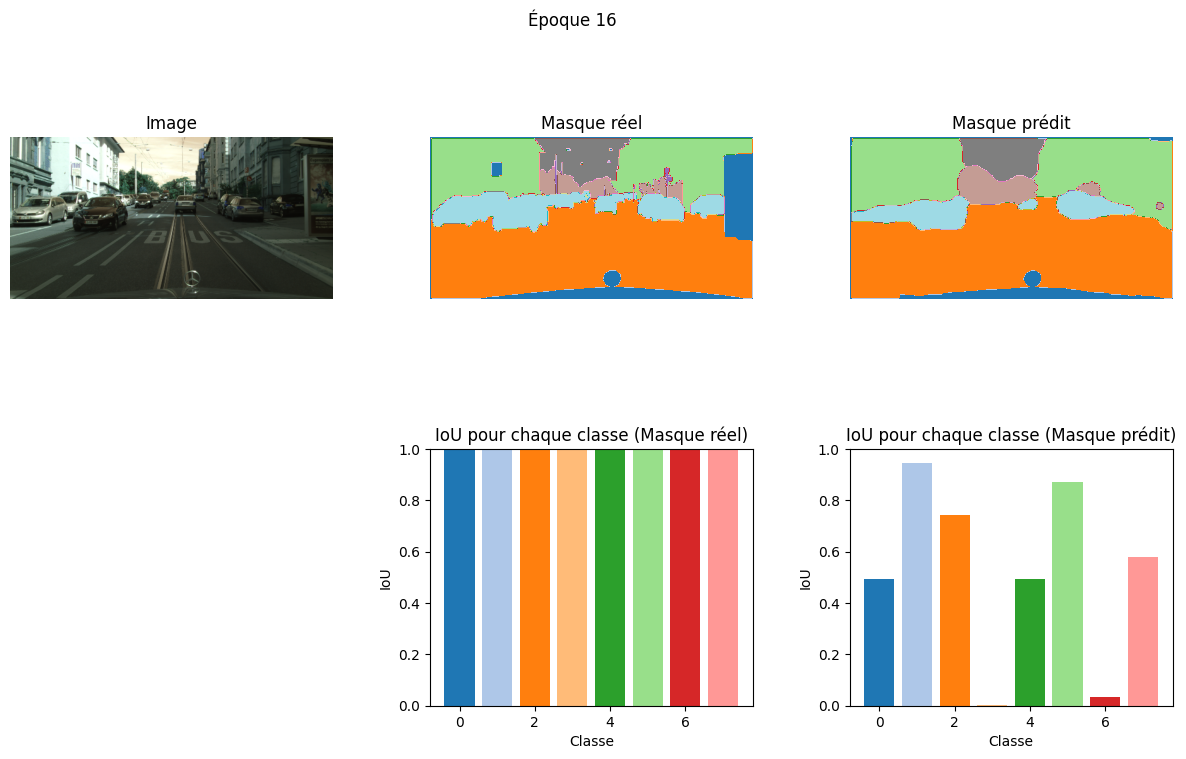

75/75 ━━━━━━━━━━━━━━━━━━━━ 635s 8s/step - accuracy: 0.8371 - dice_coeff: 0.7639 - dice_loss: 0.2361 - jaccard_score: 0.6197 - loss: 0.5173 - total_loss: 1.5787
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.8442 - dice_coeff: 0.7693 - dice_loss: 0.2307 - jaccard_score: 0.6266 


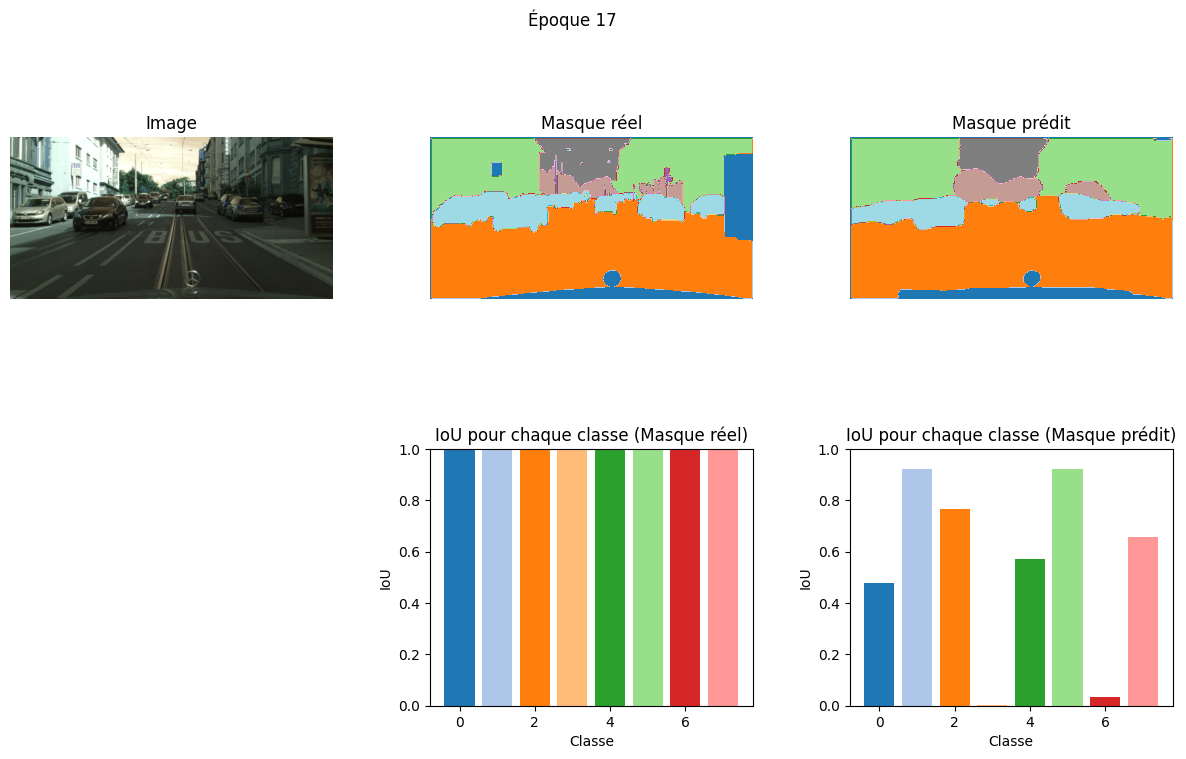

75/75 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.8443 - dice_coeff: 0.7694 - dice_loss: 0.2306 - jaccard_score: 0.6267 - loss: 0.5010 - total_loss: 1.5961
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.8419 - dice_coeff: 0.7686 - dice_loss: 0.2314 - jaccard_score: 0.6265 


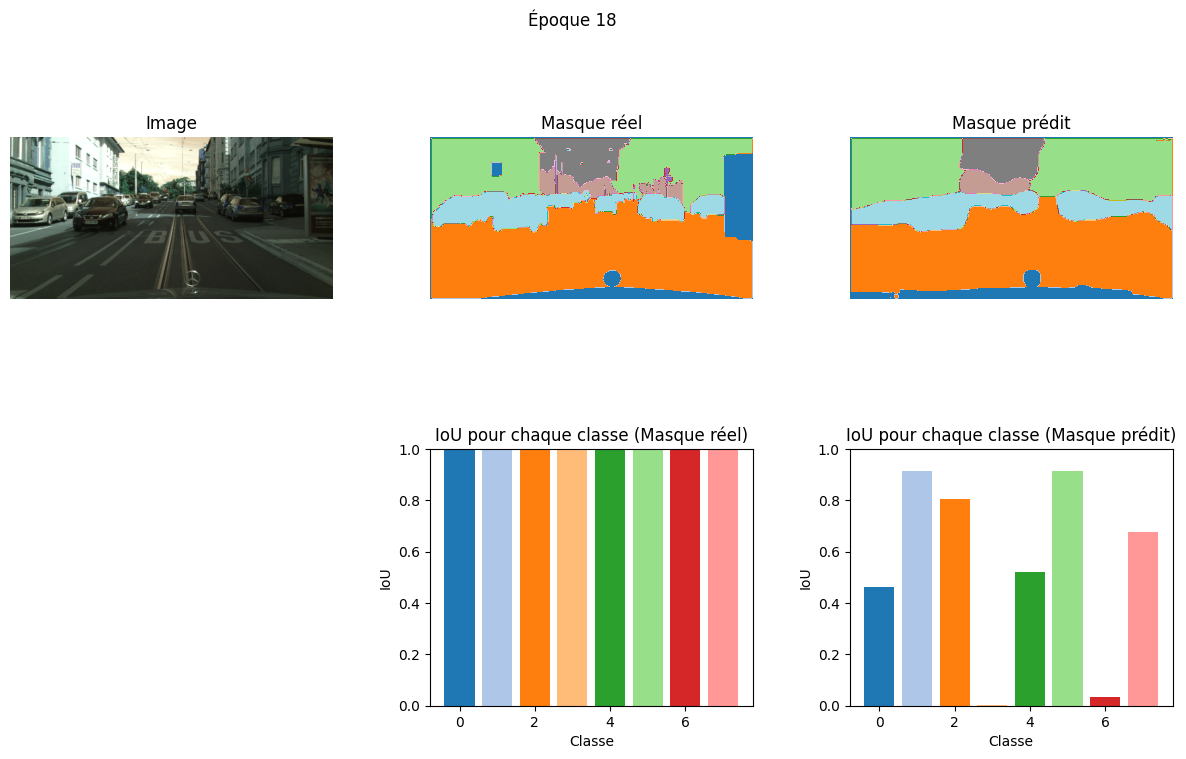

75/75 ━━━━━━━━━━━━━━━━━━━━ 631s 8s/step - accuracy: 0.8420 - dice_coeff: 0.7687 - dice_loss: 0.2313 - jaccard_score: 0.6266 - loss: 0.4990 - total_loss: 1.5858
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.8360 - dice_coeff: 0.7600 - dice_loss: 0.2400 - jaccard_score: 0.6143 


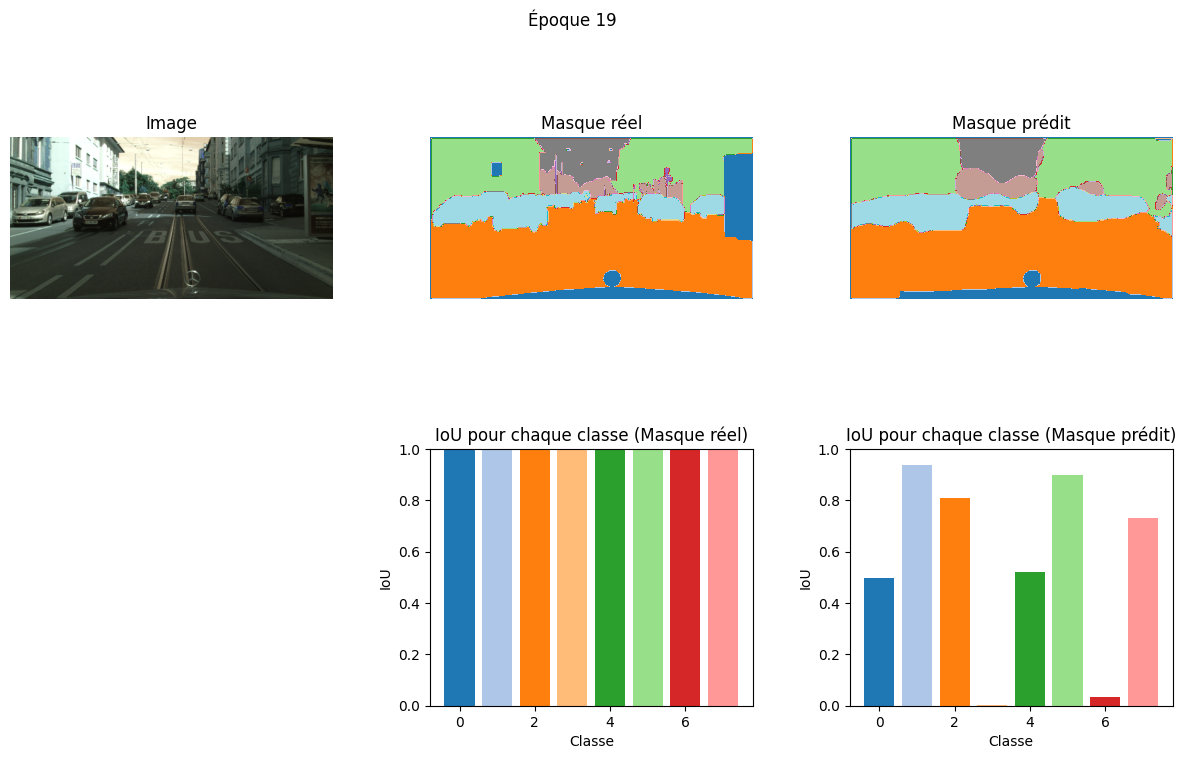

75/75 ━━━━━━━━━━━━━━━━━━━━ 634s 8s/step - accuracy: 0.8360 - dice_coeff: 0.7601 - dice_loss: 0.2399 - jaccard_score: 0.6144 - loss: 0.5220 - total_loss: 1.5955
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.8467 - dice_coeff: 0.7721 - dice_loss: 0.2279 - jaccard_score: 0.6303 


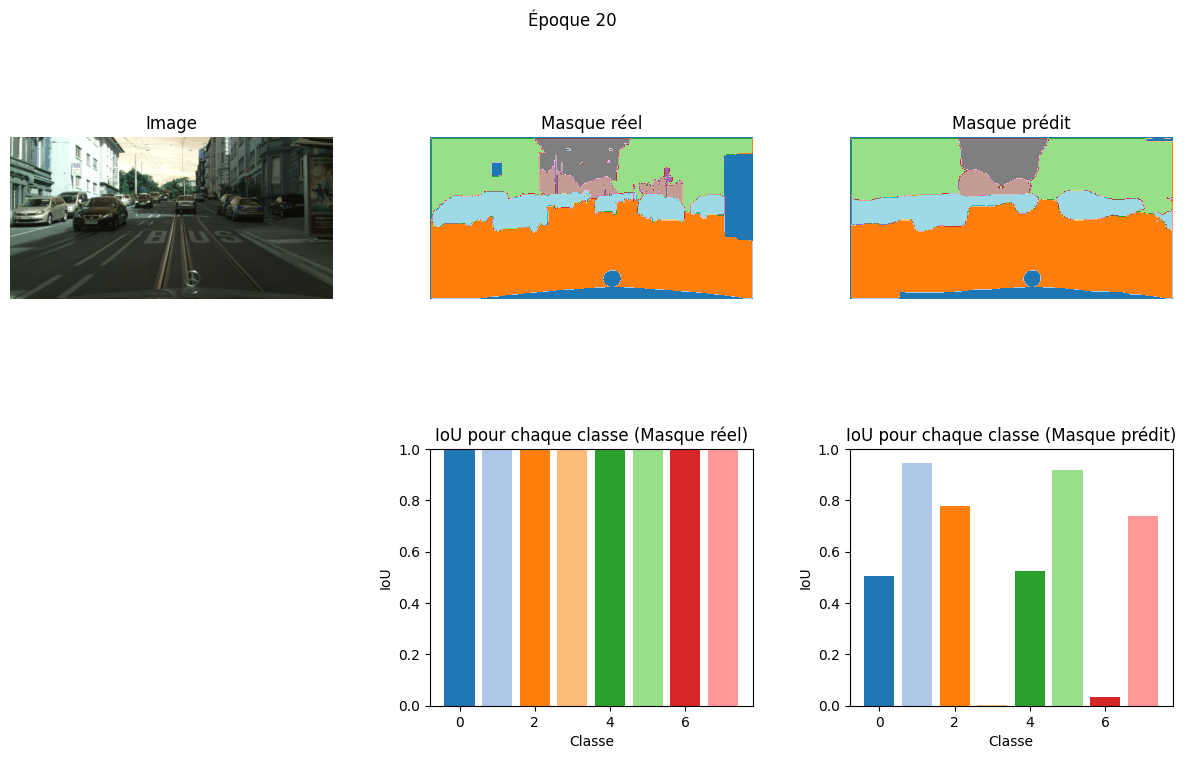

75/75 ━━━━━━━━━━━━━━━━━━━━ 625s 8s/step - accuracy: 0.8468 - dice_coeff: 0.7722 - dice_loss: 0.2278 - jaccard_score: 0.6305 - loss: 0.4978 - total_loss: 1.5892


In [29]:
# Chargement des données
images = load_images(df_train_sample)  # Charger les images
masks = load_masks(df_train_sample)    # Charger les masques

# Construction du modèle de segmentation
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 512, 3))

# Utilisation de la sortie d'un bloc intermédiaire pour conserver des détails spatiaux
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
x = layer_dict['block5_conv3'].output

# Ajout de couches de déconvolution pour la segmentation
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Dernière couche pour le nombre de classes
output = Conv2D(len(cats), (1, 1), padding='same', activation='softmax')(x)

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, dice_loss, total_loss, jaccard_score, 'accuracy'])

# Entraînement du modèle avec le callback
history = model.fit(
    images,
    masks,
    batch_size=4,
    epochs=20,
    callbacks=[PredictionCallback()]
)